In [230]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(pd.__version__)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from helper_functions import *
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

1.3.5


## Vergleich mit Isoliert/Solar

In diesem Notebook werden die Ergebnisse im main_normal.ipynb mit den isolierten Daten und den Solardaten verglichen. 

Ziele:

- Vergleich isolierte Energie ohne Import/Export mit der totalen Summe

- Vergleich Solarenergie mit der totalen Summe 

- Vergleich additives und Multiplikatives Modell

- Wie oft über 90%?

- Check Am Ende, Ob Modell Struktur wie folgt ist: Time Series = Signal + White Noise, which is not predictable

In [21]:
# Read in Data:
data = load_data('EnergieUebersichtCH-*', 'Zeitreihen0h15')
data_clean = data_cleaning(data.copy())
data_clean_loc = localize_time(data_clean.copy())
data_selected = create_features(data_clean_loc, type_='normal')
data_selected_isoliert = create_features(data_clean_loc, type_='isoliert')
data_selected_solar = create_features(data_clean_loc, type_='solar')
data_selected.head()

Strombilanz Schweiz Strombudget Schweiz  \
Zeitstempel                                                         
2008-12-31 23:15:00+00:00           85324.479         2499290.011   
2008-12-31 23:30:00+00:00           185394.37         2454567.237   
2008-12-31 23:45:00+00:00          200990.249         2496571.997   
2009-01-01 00:00:00+00:00          192894.706         2463583.914   
2009-01-01 00:15:00+00:00          199339.432         2522711.973   

                          Stromverbrauch Schweiz  
Zeitstempel                                       
2008-12-31 23:15:00+00:00            2413965.532  
2008-12-31 23:30:00+00:00            2269172.867  
2008-12-31 23:45:00+00:00            2295581.748  
2009-01-01 00:00:00+00:00            2270689.208  
2009-01-01 00:15:00+00:00            2323372.541

In [35]:
# Daten sampeln auf andere Timestamps.
data_m = data_selected.resample('M').mean()
data_4h = data_selected.resample('4h').mean()
data_d = data_selected.resample('1D').mean()

data_m_isoliert = data_selected_isoliert.resample('M').mean()
data_4h_isoliert = data_selected_isoliert.resample('4h').mean()
data_d_isoliert = data_selected_isoliert.resample('1D').mean()

data_m_solar = data_selected_solar.resample('M').mean()
data_4h_solar = data_selected_solar.resample('4h').mean()
data_d_solar = data_selected_solar.resample('1D').mean()

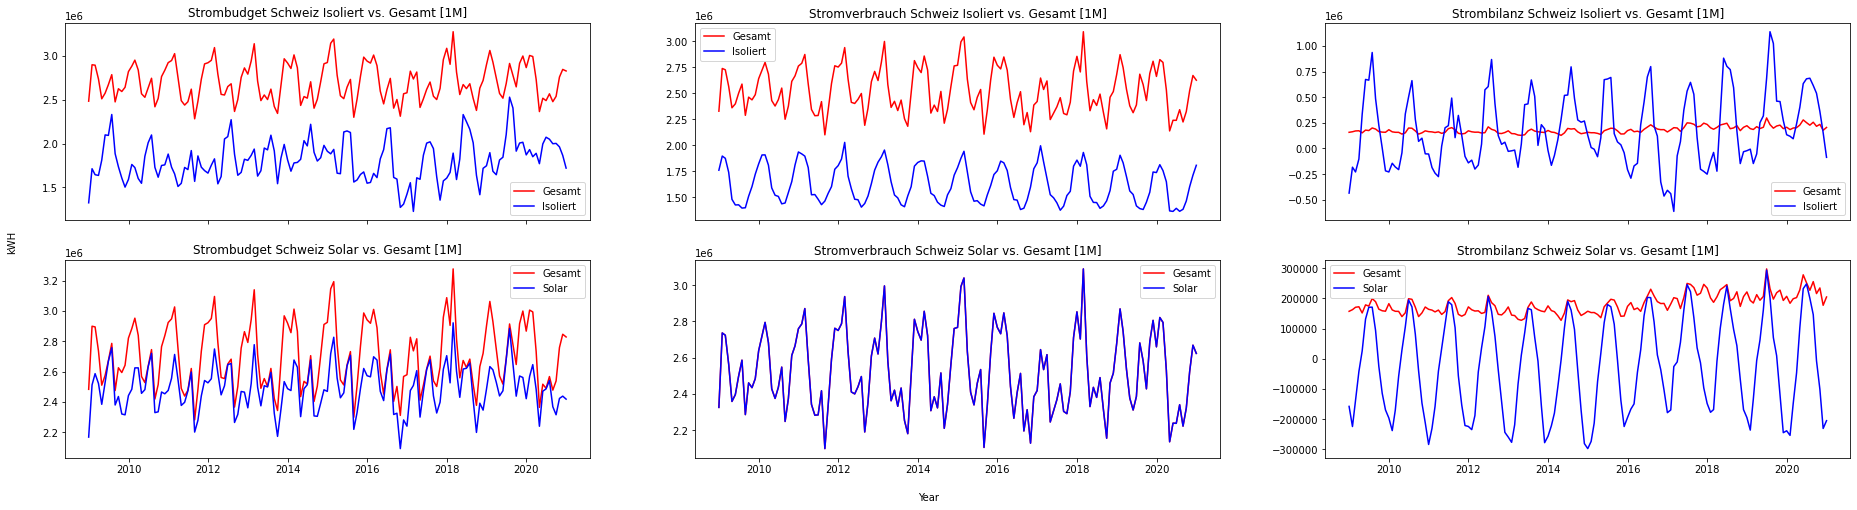

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(32,8), sharex=True)

axs[0,0].plot(data_m['Strombudget Schweiz'], "red", label="Gesamt")
axs[0,1].plot(data_m['Stromverbrauch Schweiz'], "red", label="Gesamt")
axs[0,2].plot(data_m['Strombilanz Schweiz'], "red", label="Gesamt")
axs[1,0].plot(data_m['Strombudget Schweiz'], "red", label="Gesamt")
axs[1,1].plot(data_m['Stromverbrauch Schweiz'], "red", label="Gesamt")
axs[1,2].plot(data_m['Strombilanz Schweiz'], "red", label="Gesamt")

axs[0,0].plot(data_m_isoliert['Strombudget Schweiz'], "b", label="Isoliert")
axs[0,0].set_title('Strombudget Schweiz Isoliert vs. Gesamt [1M]')
axs[0,1].plot(data_m_isoliert['Stromverbrauch Schweiz'], "b", label="Isoliert")
axs[0,1].set_title('Stromverbrauch Schweiz Isoliert vs. Gesamt [1M]')
axs[0,2].plot(data_m_isoliert['Strombilanz Schweiz'], "b", label="Isoliert")
axs[0,2].set_title('Strombilanz Schweiz Isoliert vs. Gesamt [1M]')


axs[1,0].plot(data_m_solar['Strombudget Schweiz'], "b", label="Solar")
axs[1,0].set_title('Strombudget Schweiz Solar vs. Gesamt [1M]')
axs[1,1].plot(data_m_solar['Stromverbrauch Schweiz'], "b", label="Solar")
axs[1,1].set_title('Stromverbrauch Schweiz Solar vs. Gesamt [1M]')
axs[1,2].plot(data_m_solar['Strombilanz Schweiz'], "b", label="Solar")
axs[1,2].set_title('Strombilanz Schweiz Solar vs. Gesamt [1M]')


axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
fig.text(0.5, 0.05, 'Year', ha='center')
fig.text(0.1, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Im Strombudget ist ersichtlich, dass die Schweiz über den ganzen Zeitraum mehr importiert als exportiert hat. Es gibt viele Stellen, wo die Schweiz viel Energie produziert, aber das Gesamtbudget trotzdem tiefer ist. Die isolierten Daten zeigen im Stromverbrauch glattere Spikes und 'schönere' Saisonalität. Man sieht auch, dass durch den Import/Export die Bilanz fast nicht schwankt und stets positiv ist. Importiert oder exportiert die Schweiz Energie so, dass die Bilanz insgesamt positiv ist und nicht stark steigt? Die isolierten Daten schwanken nämlich viel, viel stärker. Dasselbe ist für die Solardaten auszusagen. Hier ist zu beachten, dass die Bilanz einige Tiefs hat im Sommer, weil vielleicht weniger Energie benötigt wird.

In [7]:
ROWS_TO_SHOW = 24

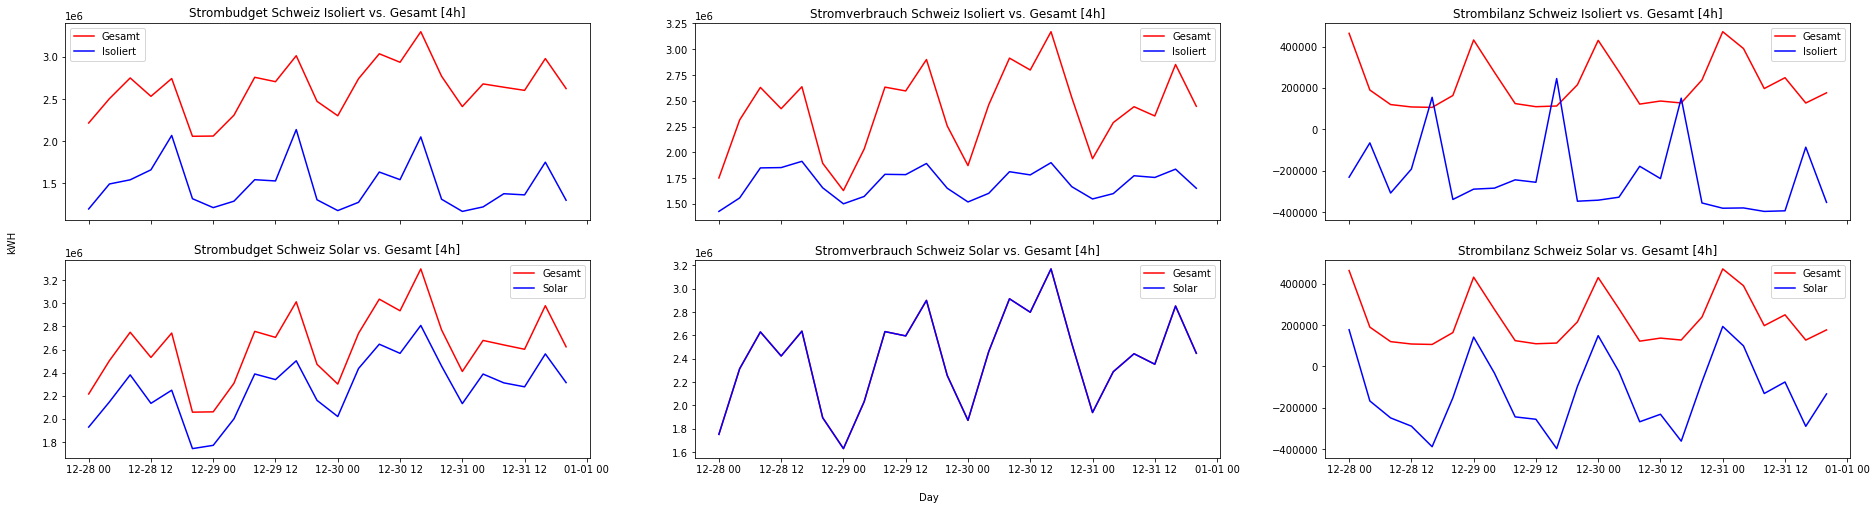

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(32,8), sharex=True)

axs[0,0].plot(data_4h['Strombudget Schweiz'].tail(ROWS_TO_SHOW), "red", label="Gesamt")
axs[0,1].plot(data_4h['Stromverbrauch Schweiz'].tail(ROWS_TO_SHOW), "red", label="Gesamt")
axs[0,2].plot(data_4h['Strombilanz Schweiz'].tail(ROWS_TO_SHOW), "red", label="Gesamt")
axs[1,0].plot(data_4h['Strombudget Schweiz'].tail(ROWS_TO_SHOW), "red", label="Gesamt")
axs[1,1].plot(data_4h['Stromverbrauch Schweiz'].tail(ROWS_TO_SHOW), "red", label="Gesamt")
axs[1,2].plot(data_4h['Strombilanz Schweiz'].tail(ROWS_TO_SHOW), "red", label="Gesamt")

axs[0,0].plot(data_4h_isoliert['Strombudget Schweiz'].tail(ROWS_TO_SHOW), "b", label="Isoliert")
axs[0,0].set_title('Strombudget Schweiz Isoliert vs. Gesamt [4h]')
axs[0,1].plot(data_4h_isoliert['Stromverbrauch Schweiz'].tail(ROWS_TO_SHOW), "b", label="Isoliert")
axs[0,1].set_title('Stromverbrauch Schweiz Isoliert vs. Gesamt [4h]')
axs[0,2].plot(data_4h_isoliert['Strombilanz Schweiz'].tail(ROWS_TO_SHOW), "b", label="Isoliert")
axs[0,2].set_title('Strombilanz Schweiz Isoliert vs. Gesamt [4h]')


axs[1,0].plot(data_4h_solar['Strombudget Schweiz'].tail(ROWS_TO_SHOW), "b", label="Solar")
axs[1,0].set_title('Strombudget Schweiz Solar vs. Gesamt [4h]')
axs[1,1].plot(data_4h_solar['Stromverbrauch Schweiz'].tail(ROWS_TO_SHOW), "b", label="Solar")
axs[1,1].set_title('Stromverbrauch Schweiz Solar vs. Gesamt [4h]')
axs[1,2].plot(data_4h_solar['Strombilanz Schweiz'].tail(ROWS_TO_SHOW), "b", label="Solar")
axs[1,2].set_title('Strombilanz Schweiz Solar vs. Gesamt [4h]')


axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
fig.text(0.5, 0.05, 'Day', ha='center')
fig.text(0.1, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

In den 4h Daten wird ersichtlich, dass die Schweiz nach 12 Uhr mittags mehr selbst und isoliert produziert. Um Mitternacht sinkt die isolierte Bilanz. Das Gesamtstrombudget sowie die Solardaten sinken gegen Abend. 

## ACF+PACF Monatlich Isoliert

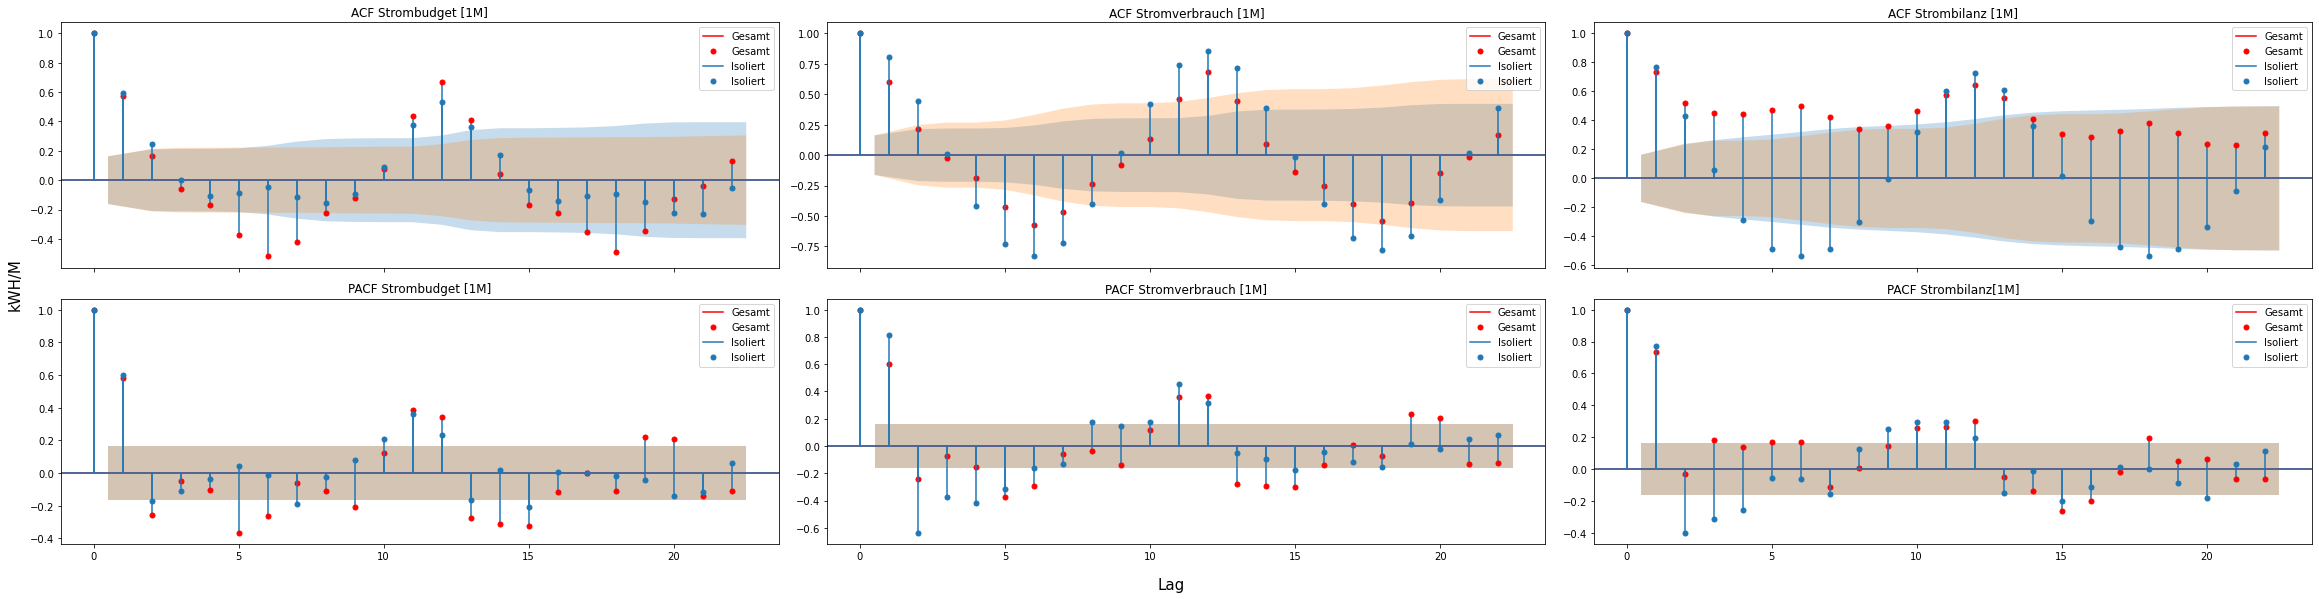

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(32,8), sharex=True)

plot_acf(data_m['Strombudget Schweiz'], title='ACF Strombudget [1M]', ax=axs[0,0], color="red", label='Gesamt')
plot_acf(data_m['Stromverbrauch Schweiz'], title='ACF Stromverbrauch [1M]', ax=axs[0,1], color="red", label='Gesamt')
plot_acf(data_m['Strombilanz Schweiz'], title='ACF Strombilanz [1M]', ax=axs[0,2], color="red", label='Gesamt')

plot_acf(data_m_isoliert['Strombudget Schweiz'], title='ACF Strombudget [1M]', ax=axs[0,0], label='Isoliert')
plot_acf(data_m_isoliert['Stromverbrauch Schweiz'], title='ACF Stromverbrauch [1M]', ax=axs[0,1], label='Isoliert')
plot_acf(data_m_isoliert['Strombilanz Schweiz'], title='ACF Strombilanz [1M]', ax=axs[0,2], label='Isoliert')

plot_pacf(data_m['Strombudget Schweiz'], title='PACF Strombudget [1M]', ax=axs[1,0], color="red", label='Gesamt')
plot_pacf(data_m['Stromverbrauch Schweiz'], title='PACF Stromverbrauch [1M]', ax=axs[1,1], color="red", label='Gesamt')
plot_pacf(data_m['Strombilanz Schweiz'], title='PACF Strombilanz [1M]', ax=axs[1,2], color="red", label='Gesamt')

plot_pacf(data_m_isoliert['Strombudget Schweiz'], title='PACF Strombudget [1M]', ax=axs[1,0], label='Isoliert')
plot_pacf(data_m_isoliert['Stromverbrauch Schweiz'], title='PACF Stromverbrauch [1M]', ax=axs[1,1], label='Isoliert')
plot_pacf(data_m_isoliert['Strombilanz Schweiz'], title='PACF Strombilanz[1M]', ax=axs[1,2], label='Isoliert')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()

fig.text(0.5, -0.03, 'Lag', ha='center', size=15)
fig.text(-0.005, 0.5, 'kWH/M', va='center', rotation='vertical', size=15)
plt.tight_layout()
plt.show()

Der ACF Plot des gesamten Strombudgets, sowie der isolierten Daten zeigen eine sinusfürmige Beziehung mit einem Lag von 12 Monaten, also genau einem Jahr. Die Autokorrelation nach 6 Monaten ist auch im negativen Bereich, was die Beziehung zwischen Sommer und Winter zeigt. In der gesamten Strombilanz fehlt diese Beziehung. Wie schon angesprochen bleibt die Gesamtbilanz mehr oder weniger stets positiv und hat keine grossen Schwankungen. Das heisst vielleicht, dass die kleinen Schwankungen in der Bilanz nicht in den monatlichen Daten ersichtbar sind, sondern dass man tiefer reinschauen muss. Die Signifikanz der Werte ist wie gewohnt bei späteren Monaten kleiner.

## ACF + PACF Monatlich Solar

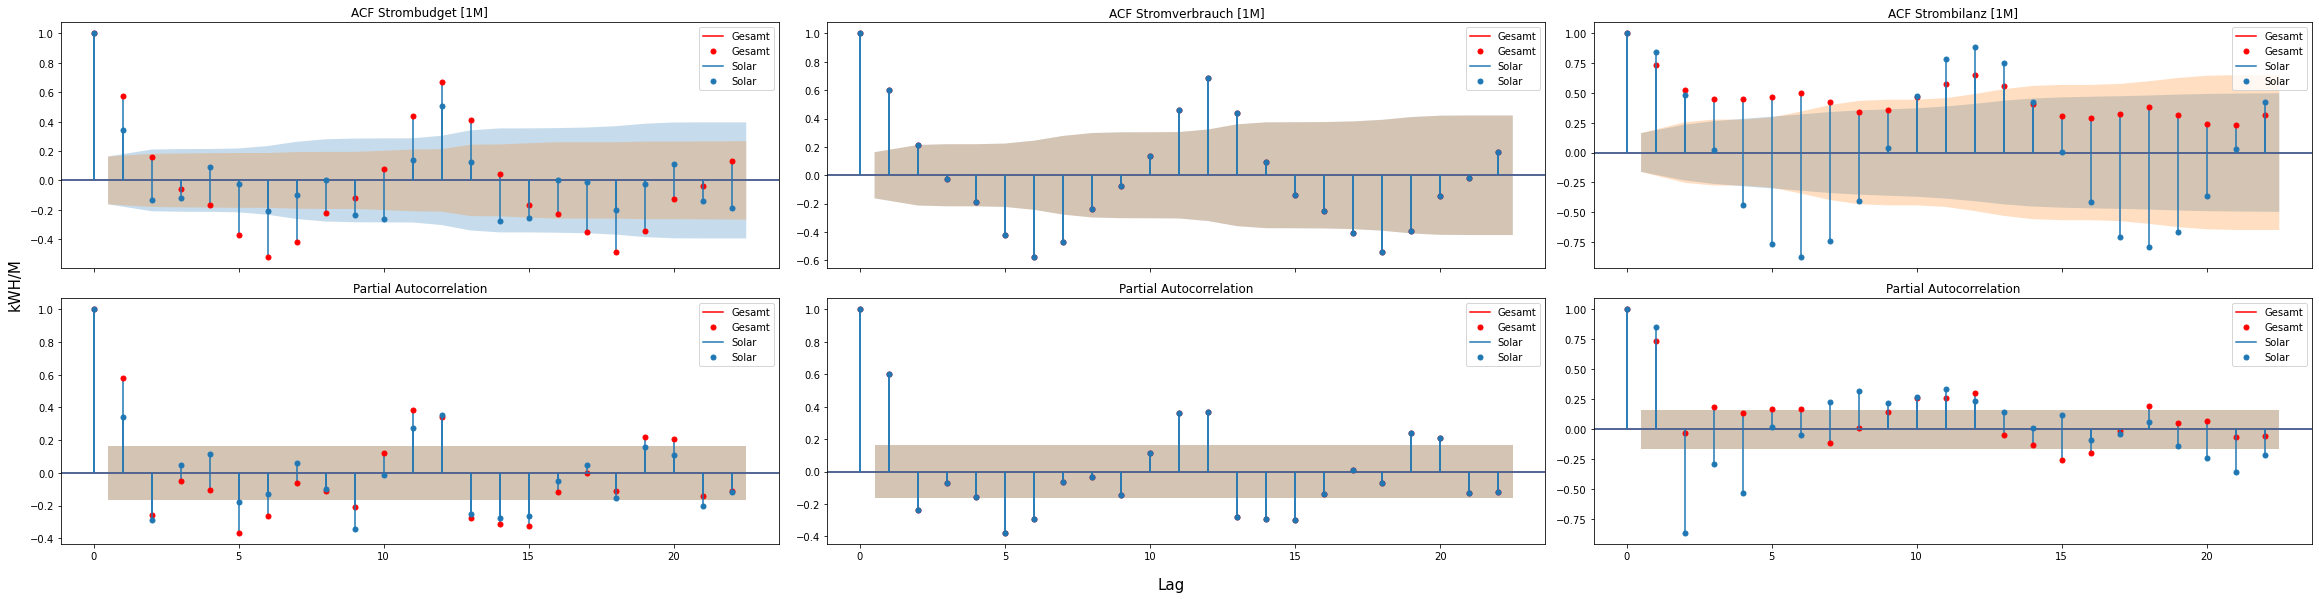

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(32,8), sharex=True)

plot_acf(data_m['Strombudget Schweiz'], title='ACF Strombudget [1M]', ax=axs[0,0], color="red", label='Gesamt')
plot_acf(data_m['Stromverbrauch Schweiz'], title='acF Stromverbrauch [1M]', ax=axs[0,1], color="red", label='Gesamt')
plot_acf(data_m['Strombilanz Schweiz'], title='ACF Strombilanz [1M]', ax=axs[0,2], color="red", label='Gesamt')

plot_acf(data_m_solar['Strombudget Schweiz'], title='ACF Strombudget [1M]', ax=axs[0,0], label='Solar')
plot_acf(data_m_solar['Stromverbrauch Schweiz'], title='ACF Stromverbrauch [1M]', ax=axs[0,1], label='Solar')
plot_acf(data_m_solar['Strombilanz Schweiz'], title='ACF Strombilanz [1M]', ax=axs[0,2], label='Solar')

plot_pacf(data_m['Strombudget Schweiz'], title='PACF Strombudget [1M]', ax=axs[1,0], color="red", label='Gesamt')
plot_pacf(data_m['Stromverbrauch Schweiz'], title='PACF Stromverbrauch [1M]', ax=axs[1,1], color="red", label='Gesamt')
plot_pacf(data_m['Strombilanz Schweiz'], title='PACF Strombilanz [1M]', ax=axs[1,2], color="red", label='Gesamt')

plot_pacf(data_m_solar['Strombudget Schweiz'], ax=axs[1,0], label='Solar')
plot_pacf(data_m_solar['Stromverbrauch Schweiz'], ax=axs[1,1], label='Solar')
plot_pacf(data_m_solar['Strombilanz Schweiz'], ax=axs[1,2], label='Solar')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()

fig.text(0.5, -0.03, 'Lag', ha='center', size=15)
fig.text(-0.005, 0.5, 'kWH/M', va='center', rotation='vertical', size=15)
plt.tight_layout()
plt.show()

Bei den Autokorrelationsplots für die Solardaten sind die Lags signifikanter bei den ACF und PACF Plots. Das sieht man auch in der Zeitreihe oben, wo es in der Bilanz starke Schwankungen gibt.

#### 4-Stunden Daten, gemittelt über mehrere Jahre

In [11]:
data_4h_average = data_4h.copy()
data_4h_average_isoliert = data_4h_isoliert.copy()
data_4h_average_solar = data_4h_solar.copy()

data_4h_average['datetime'] = data_4h_average.index.strftime("%d-%m %H:%M")
data_4h_average_isoliert['datetime'] = data_4h_average_isoliert.index.strftime("%d-%m %H:%M")
data_4h_average_solar['datetime'] = data_4h_average_solar.index.strftime("%d-%m %H:%M")

data_4h_average = data_4h_average.groupby(data_4h_average.datetime).mean()
data_4h_average_isoliert = data_4h_average_isoliert.groupby(data_4h_average_isoliert.datetime).mean()
data_4h_average_solar = data_4h_average_solar.groupby(data_4h_average_solar.datetime).mean()

## ACF + PACF 4H Daten Isoliert

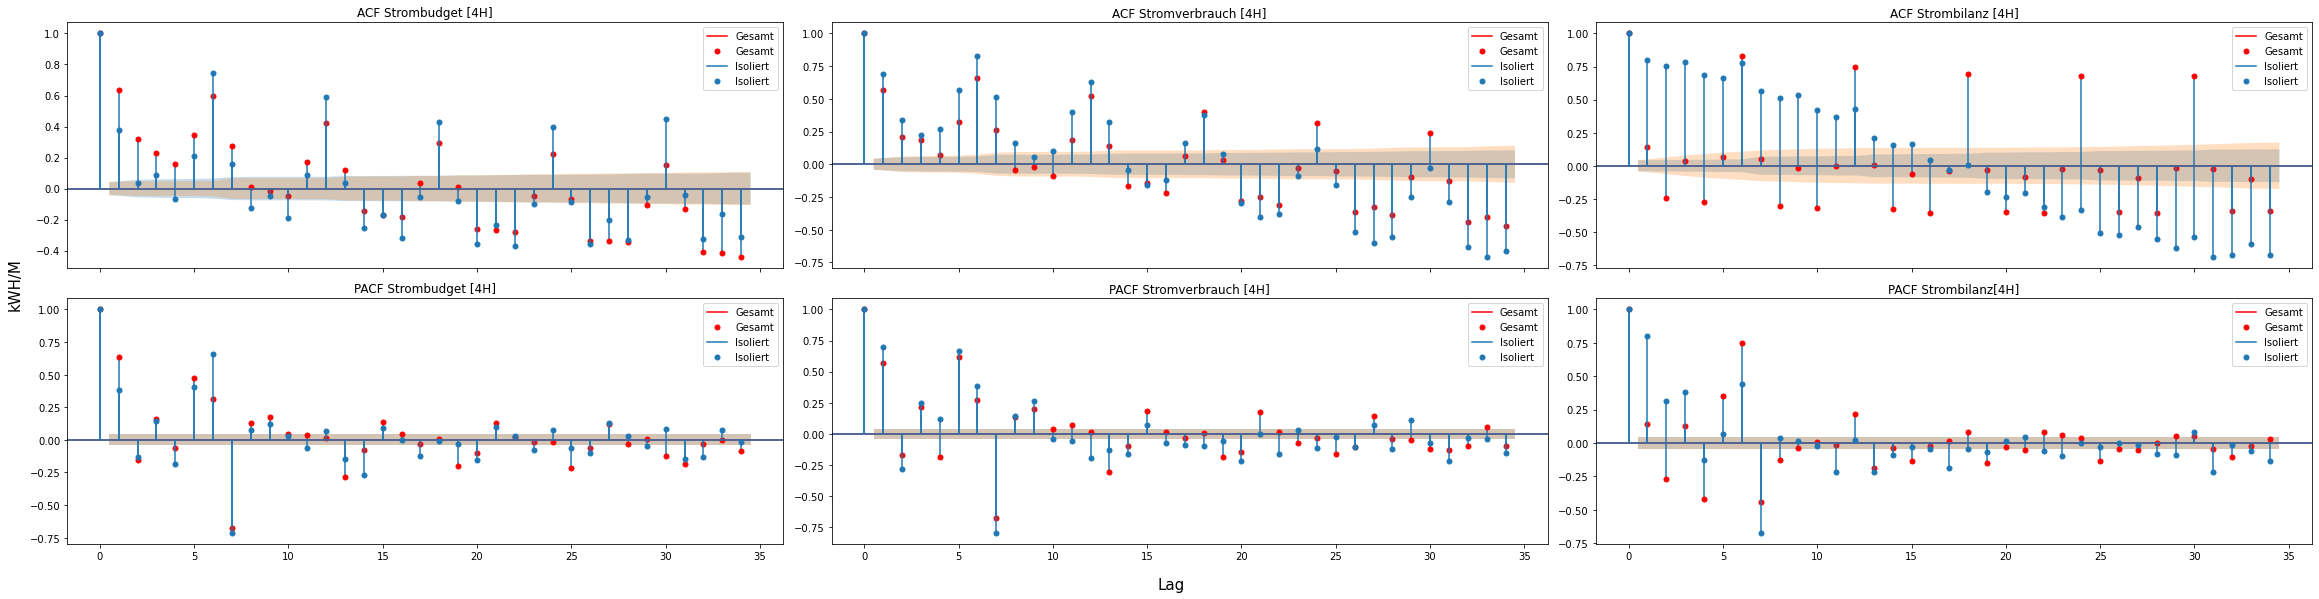

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(32,8), sharex=True)

plot_acf(data_4h_average['Strombudget Schweiz'], title='ACF Strombudget [4H]', ax=axs[0,0], color="red", label='Gesamt')
plot_acf(data_4h_average['Stromverbrauch Schweiz'], title='ACF Stromverbrauch [4H]', ax=axs[0,1], color="red", label='Gesamt')
plot_acf(data_4h_average['Strombilanz Schweiz'], title='ACF Strombilanz [4H]', ax=axs[0,2], color="red", label='Gesamt')

plot_acf(data_4h_average_isoliert['Strombudget Schweiz'], title='ACF Strombudget [4H]', ax=axs[0,0], label='Isoliert')
plot_acf(data_4h_average_isoliert['Stromverbrauch Schweiz'], title='ACF Stromverbrauch [4H]', ax=axs[0,1], label='Isoliert')
plot_acf(data_4h_average_isoliert['Strombilanz Schweiz'], title='ACF Strombilanz [4H]', ax=axs[0,2], label='Isoliert')

plot_pacf(data_4h_average['Strombudget Schweiz'], title='PACF Strombudget [4H]', ax=axs[1,0], color="red", label='Gesamt')
plot_pacf(data_4h_average['Stromverbrauch Schweiz'], title='PACF Stromverbrauch [4H]', ax=axs[1,1], color="red", label='Gesamt')
plot_pacf(data_4h_average['Strombilanz Schweiz'], title='PACF Strombilanz [4H]', ax=axs[1,2], color="red", label='Gesamt')

plot_pacf(data_4h_average_isoliert['Strombudget Schweiz'], title='PACF Strombudget [4H]', ax=axs[1,0], label='Isoliert')
plot_pacf(data_4h_average_isoliert['Stromverbrauch Schweiz'], title='PACF Stromverbrauch [4H]', ax=axs[1,1], label='Isoliert')
plot_pacf(data_4h_average_isoliert['Strombilanz Schweiz'], title='PACF Strombilanz[4H]', ax=axs[1,2], label='Isoliert')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()

fig.text(0.5, -0.03, 'Lag', ha='center', size=15)
fig.text(-0.005, 0.5, 'kWH/M', va='center', rotation='vertical', size=15)
plt.tight_layout()
plt.show()

## ACF + PACF 4H Daten Solar

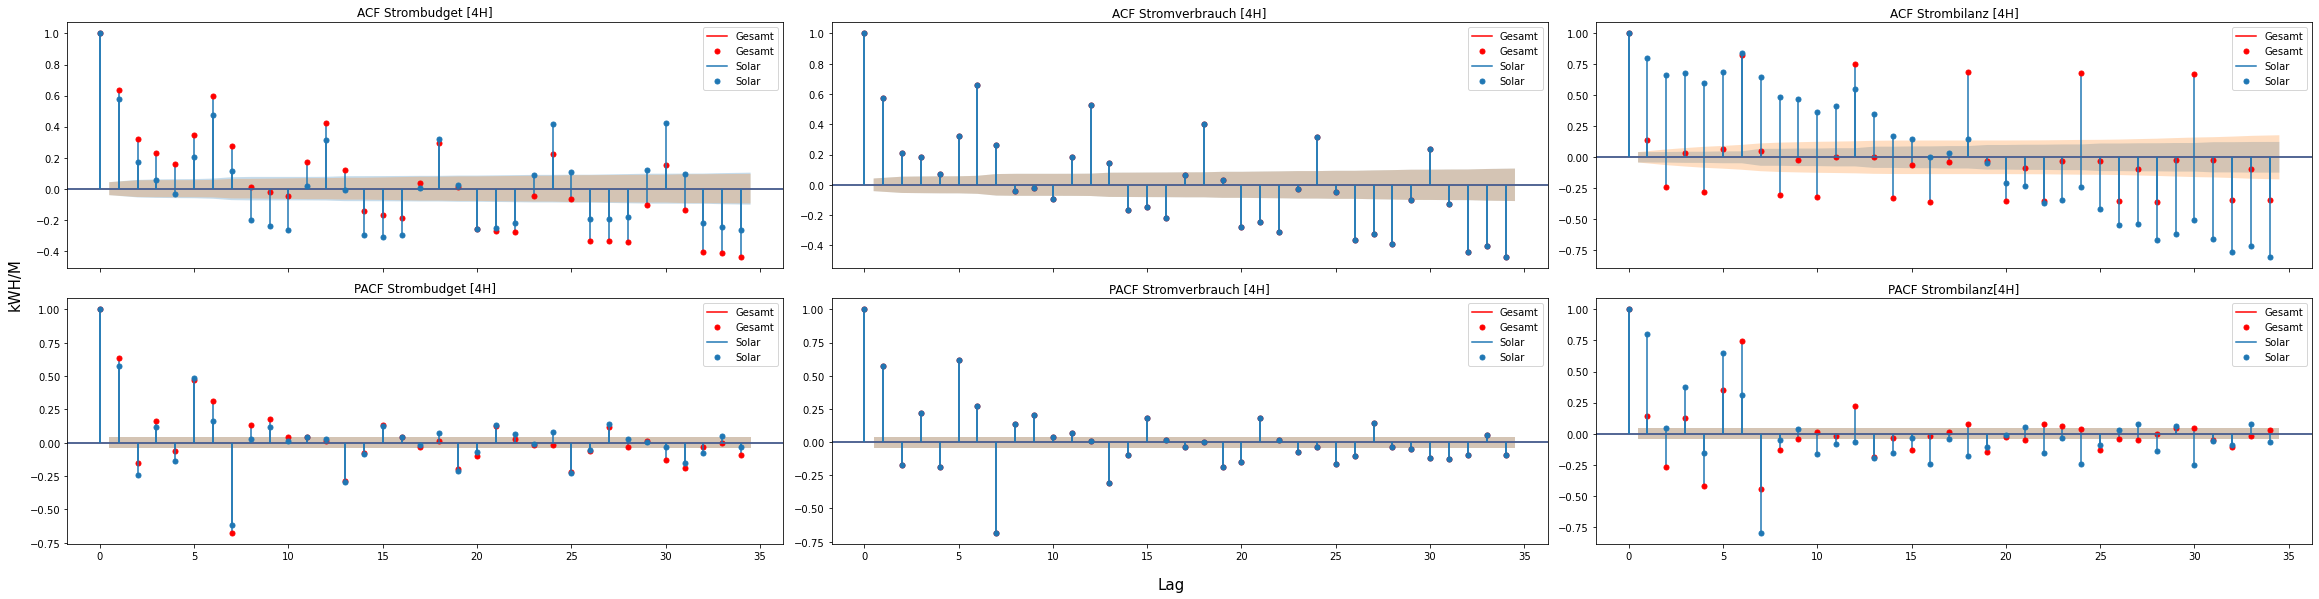

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(32,8), sharex=True)

plot_acf(data_4h_average['Strombudget Schweiz'], title='ACF Strombudget [4H]', ax=axs[0,0], color="red", label='Gesamt')
plot_acf(data_4h_average['Stromverbrauch Schweiz'], title='ACF Stromverbrauch [4H]', ax=axs[0,1], color="red", label='Gesamt')
plot_acf(data_4h_average['Strombilanz Schweiz'], title='ACF Strombilanz [4H]', ax=axs[0,2], color="red", label='Gesamt')

plot_acf(data_4h_average_solar['Strombudget Schweiz'], title='ACF Strombudget [4H]', ax=axs[0,0], label='Solar')
plot_acf(data_4h_average_solar['Stromverbrauch Schweiz'], title='ACF Stromverbrauch [4H]', ax=axs[0,1], label='Solar')
plot_acf(data_4h_average_solar['Strombilanz Schweiz'], title='ACF Strombilanz [4H]', ax=axs[0,2], label='Solar')

plot_pacf(data_4h_average['Strombudget Schweiz'], title='PACF Strombudget [4H]', ax=axs[1,0], color="red", label='Gesamt')
plot_pacf(data_4h_average['Stromverbrauch Schweiz'], title='PACF Stromverbrauch [4H]', ax=axs[1,1], color="red", label='Gesamt')
plot_pacf(data_4h_average['Strombilanz Schweiz'], title='PACF Strombilanz [4H]', ax=axs[1,2], color="red", label='Gesamt')

plot_pacf(data_4h_average_solar['Strombudget Schweiz'], title='PACF Strombudget [4H]', ax=axs[1,0], label='Solar')
plot_pacf(data_4h_average_solar['Stromverbrauch Schweiz'], title='PACF Stromverbrauch [4H]', ax=axs[1,1], label='Solar')
plot_pacf(data_4h_average_solar['Strombilanz Schweiz'], title='PACF Strombilanz[4H]', ax=axs[1,2], label='Solar')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()

fig.text(0.5, -0.03, 'Lag', ha='center', size=15)
fig.text(-0.005, 0.5, 'kWH/M', va='center', rotation='vertical', size=15)
plt.tight_layout()
plt.show()

IM ACF Plot der isolierten Daten ist in der Bilanz eine viel breitere sinusförmige Beziehung in den 4h Daten erkennbar. Der Lag hier wäre vielleicht hochgerechnet eine ganze Woche. In den übrigen Plots sieht man Lags von 6 was einem Tag entspräche. Die Lags sind sehr signifikant. Die Daten sind gelaggt sehr korreliert.

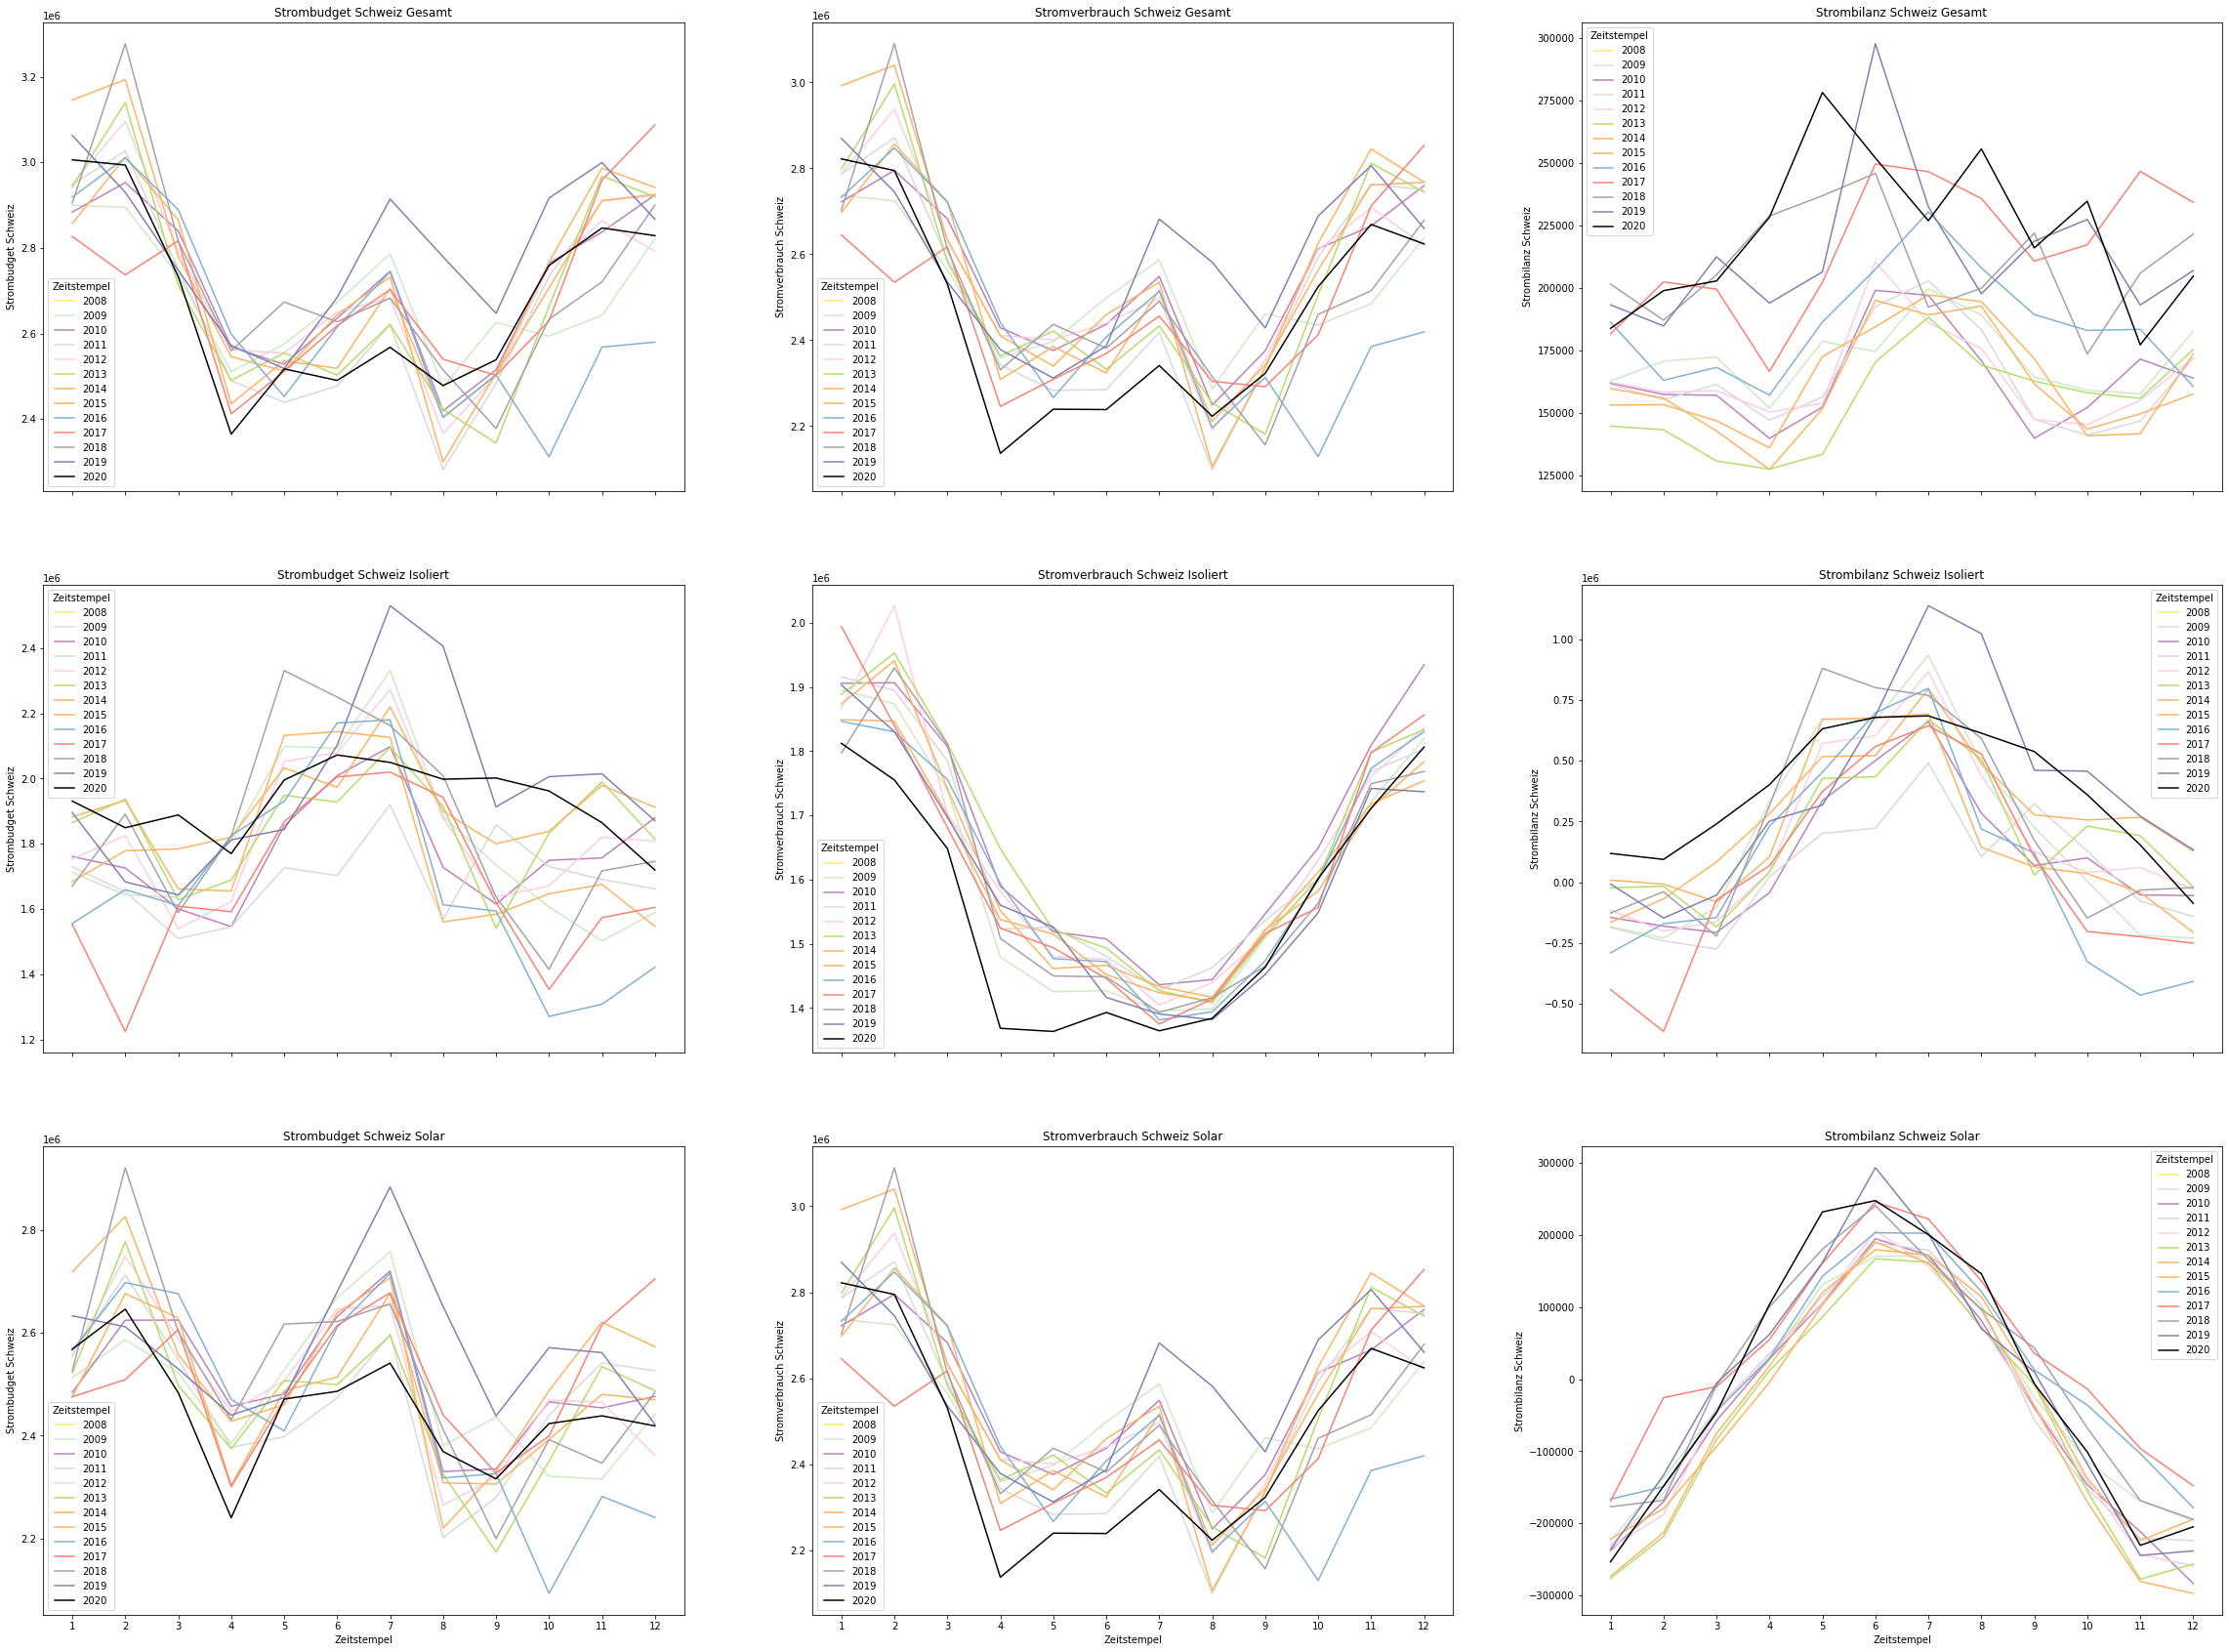

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(40,30), sharex=True)

data = [data_m, data_m_isoliert, data_m_solar]
data_name = ["Gesamt", "Isoliert", "Solar"]
y = ["Strombudget Schweiz", "Stromverbrauch Schweiz", "Strombilanz Schweiz"]
colors = [(1.0, 0.9294117647058824, 0.43529411764705883), (0.8, 0.9215686274509803, 0.7725490196078432), (0.7372549019607844, 0.5019607843137255, 0.7411764705882353), (0.8509803921568627, 0.8509803921568627, 0.8509803921568627), (0.9882352941176471, 0.803921568627451, 0.8980392156862745), (0.7019607843137254, 0.8705882352941177, 0.4117647058823529), (0.9921568627450981, 0.7058823529411765, 0.3843137254901961), (0.9921568627450981, 0.7058823529411765, 0.3843137254901961), (0.5019607843137255, 0.6941176470588235, 0.8274509803921568), (0.984313725490196, 0.5019607843137255, 0.4470588235294118), (0.6450980392156863, 0.6294117647058823, 0.6549019607843137), (0.5, 0.5, 0.7019607843137254), (0,0,0)]
for i in range(len(data)):
    for j in range(len(y)):
        sns.lineplot(data = data[i],
                     x = data[i].index.month,
                     y = y[j],
                     hue = data[i].index.year,
                     ax = axs[i,j], legend='full', palette=colors)
        axs[i,j].set_xticks(range(1,13))
        axs[i,j].set_title(y[j] + " " + data_name[i])

plt.show()

In allen Kategorien nimmt der Sromverbrauch im April stark ab. Wenn man das Budget zwischen Gesamt, Isoliert und Solar vergleicht, erkennt man, dass die Schweiz eine gute Bilanz hat und vielleicht auch selber viel produziert im Vergleich zum kleinen Verbrauch. In Wintermonaten ist aber der Stromverbrauch sehr hoch. Man sieht auch beim Verbrauch, dass es mehr Export gibt im Sommer, da die isolierten Daten kein grosser Verbrauch zeigen, die Daten mit dem Export aber schon. Die Bilanz der Solardaten ist smoother, als die der anderen Daten. Bei der Strombilanz Gesamt sind die Unterschiede zwischen den Jahren sehr gross, aber das kann auch an der y-Achse liegen. 

Die Solardatenbilanz ist viel schöner, als die der anderen Daten. 

2019 war ein Jahr wo viel produziert wurde und auch viel verbraucht wurde. Es gibt also einige Jahre, die man auch als Aussenseiter sehen könnte.
2020 war auch ein Jahr wo ausserordentlich wenig im April verbraucht wurde.

## Mean und Std Plots

### Strombudget Isoliert und Solar

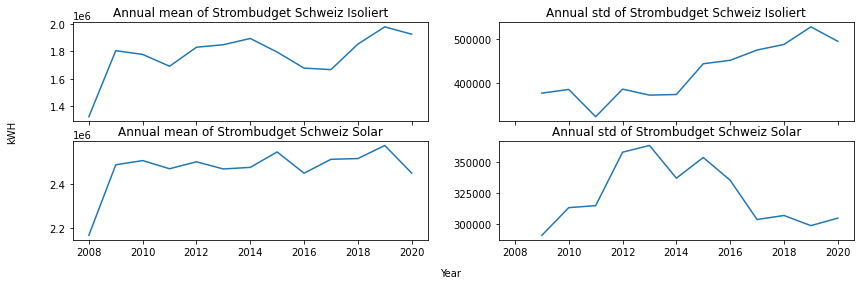

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(14,4), sharex=True)
ax[0,0].plot(data_4h_isoliert.groupby(data_4h_isoliert.index.year).mean()["Strombudget Schweiz"])
ax[0,0].set_title('Annual mean of Strombudget Schweiz Isoliert')
ax[0,1].plot(data_4h_isoliert.groupby(data_4h_isoliert.index.year).std()["Strombudget Schweiz"])
ax[0,1].set_title('Annual std of Strombudget Schweiz Isoliert')
ax[1,0].plot(data_4h_solar.groupby(data_4h_solar.index.year).mean()["Strombudget Schweiz"])
ax[1,0].set_title('Annual mean of Strombudget Schweiz Solar')
ax[1,1].plot(data_4h_solar.groupby(data_4h_solar.index.year).std()["Strombudget Schweiz"])
ax[1,1].set_title('Annual std of Strombudget Schweiz Solar')

fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

### Stromverbrauch Isoliert und Solar

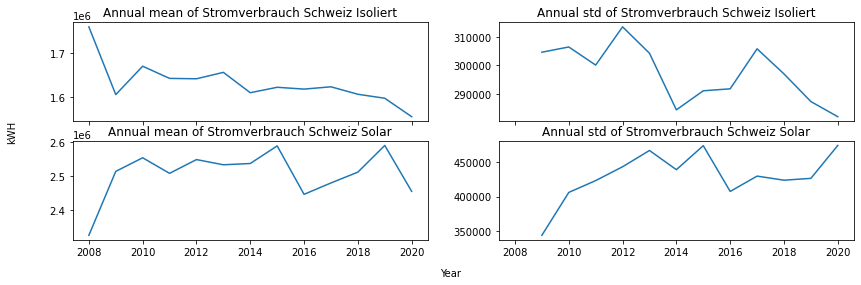

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(14,4), sharex=True)
ax[0,0].plot(data_4h_isoliert.groupby(data_4h_isoliert.index.year).mean()["Stromverbrauch Schweiz"])
ax[0,0].set_title('Annual mean of Stromverbrauch Schweiz Isoliert')
ax[0,1].plot(data_4h_isoliert.groupby(data_4h_isoliert.index.year).std()["Stromverbrauch Schweiz"])
ax[0,1].set_title('Annual std of Stromverbrauch Schweiz Isoliert')
ax[1,0].plot(data_4h_solar.groupby(data_4h_solar.index.year).mean()["Stromverbrauch Schweiz"])
ax[1,0].set_title('Annual mean of Stromverbrauch Schweiz Solar')
ax[1,1].plot(data_4h_solar.groupby(data_4h_solar.index.year).std()["Stromverbrauch Schweiz"])
ax[1,1].set_title('Annual std of Stromverbrauch Schweiz Solar')

fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

### Strombilanz Isoliert und Solar

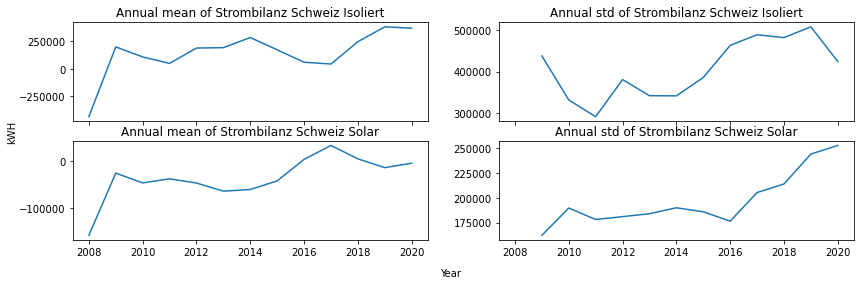

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14,4), sharex=True)
ax[0,0].plot(data_4h_isoliert.groupby(data_4h_isoliert.index.year).mean()["Strombilanz Schweiz"])
ax[0,0].set_title('Annual mean of Strombilanz Schweiz Isoliert')
ax[0,1].plot(data_4h_isoliert.groupby(data_4h_isoliert.index.year).std()["Strombilanz Schweiz"])
ax[0,1].set_title('Annual std of Strombilanz Schweiz Isoliert')
ax[1,0].plot(data_4h_solar.groupby(data_4h_solar.index.year).mean()["Strombilanz Schweiz"])
ax[1,0].set_title('Annual mean of Strombilanz Schweiz Solar')
ax[1,1].plot(data_4h_solar.groupby(data_4h_solar.index.year).std()["Strombilanz Schweiz"])
ax[1,1].set_title('Annual std of Strombilanz Schweiz Solar')

fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Ausser bei der Standardabweichung der Strombilanz der Solardaten kann man nicht mit Sicherheit sagen, ob die Varianz gross mit dem Mittelwert steigt. Man muss ein additives mit einem multiplikativem vergleichen, um eine Aussage zu machen.

## Train-Test Split

Wie im main_normal.ipynb Teil der Arbeit wurden die Daten aufgeteilt ind Training- und Testset. Das Splitdatum ist wieder der 31. Dez 2017 um 00:00 Uhr. Dadurch haben wir eine Zeitspanne von 9 Jahren im Trainingsset und 3 Jahre im Testset.

In [260]:
data_4h_train, data_4h_test = data_4h[:'2017-12-31 00:00:00+00:00'], data_4h['2017-12-31 00:00:00+00:00':]
data_4h_isoliert_train, data_4h_isoliert_test = data_4h_isoliert[:'2017-12-31 00:00:00+00:00'], data_4h_isoliert['2017-12-31 00:00:00+00:00':]
data_4h_solar_train, data_4h_solar_test = data_4h_solar[:'2017-12-31 00:00:00+00:00'], data_4h_solar['2017-12-31 00:00:00+00:00':]

isoliert_sum_constant = 1103207
solar_sum_constant = 700000

def predict_future(df, days):
    '''extends the timeseries n days into the future'''
    base = df.index[0]

    for _ in range(6 * days):
        df=df.append({"trend_pred":df.iloc[-1][0] - (df.iloc[-2][0] - df.iloc[-1][0]),"annual_season":df.iloc[-365*6][1],
                         "weekly_season":df.iloc[-7*6][2],"daily_season":df.iloc[-6][3]}, ignore_index=True)   
    index_list=[]
    for x in range(len(df)):
        index_list.append(base)
        base += datetime.timedelta(hours=4)
    df["reconstructed"] = df["trend_pred"] * df["annual_season"] * df["weekly_season"] * df["daily_season"]

    # Set index to timesamp
    df["timestamp"] = index_list
    df = df.set_index("timestamp")
    return df

def decomposition_multiplicative(df):
    '''Decomposes a given pandas series into a trend, annual, monthly, weekly and daily season'''
    # daily season
    d = seasonal_decompose(df, period=6, model="multiplicative", two_sided=False)
    r = df / d.seasonal
    # monthly season
    w = seasonal_decompose(r, period=6*7, model="multiplicative", two_sided=False)
    r = r / w.seasonal
    # annual season
    a = seasonal_decompose(r, period=6*365, model="multiplicative", two_sided=False)
    r = r / a.seasonal
    return a, d, w

def decomposition_additive(df):
    '''Decomposes a given pandas series into a trend, annual, monthly, weekly and daily season'''
    # daily season
    d = seasonal_decompose(df, period=6, model="additive", two_sided=False)
    r = df / d.seasonal
    # monthly season
    w = seasonal_decompose(r, period=6*7, model="additive", two_sided=False)
    r = r / w.seasonal
    # annual season
    a = seasonal_decompose(r, period=6*365, model="additive", two_sided=False)
    r = r / a.seasonal
    return a, d, w

def ols_trend(df, trend):
    "calculates an ols linear trend"
    X = np.arange(len(trend.trend.dropna())).reshape(-1,1)
    y = trend.trend.dropna().values
    reg = LinearRegression().fit(X, y)
    return reg.predict(np.arange(len(trend.trend)).reshape(-1,1))

# seasonal decomposition
a_v_total, d_v_total, w_v_total = decomposition_multiplicative(data_4h_train["Stromverbrauch Schweiz"])
a_p_total, d_p_total, w_p_total = decomposition_multiplicative(data_4h_train["Strombudget Schweiz"])
a_b_total, d_b_total, w_b_total = decomposition_multiplicative(data_4h_train["Strombilanz Schweiz"])

# seasonal decomposition
a_v_isoliert, d_v_isoliert, w_v_isoliert = decomposition_multiplicative(data_4h_isoliert_train["Stromverbrauch Schweiz"])
a_p_isoliert, d_p_isoliert, w_p_isoliert = decomposition_multiplicative(data_4h_isoliert_train["Strombudget Schweiz"])
a_b_isoliert, d_b_isoliert, w_b_isoliert = decomposition_multiplicative(data_4h_isoliert_train["Strombilanz Schweiz"] + isoliert_sum_constant)

# seasonal decomposition
a_v_solar, d_v_solar, w_v_solar = decomposition_multiplicative(data_4h_solar_train["Stromverbrauch Schweiz"])
a_p_solar, d_p_solar, w_p_solar = decomposition_multiplicative(data_4h_solar_train["Strombudget Schweiz"])
a_b_solar, d_b_solar, w_b_solar = decomposition_multiplicative(data_4h_solar_train["Strombilanz Schweiz"] + solar_sum_constant)

# predict trend
trend_pred_v_total = ols_trend(data_4h["Stromverbrauch Schweiz"], a_v_total)
trend_pred_p_total = ols_trend(data_4h["Strombudget Schweiz"], a_p_total)
trend_pred_b_total = ols_trend(data_4h["Strombilanz Schweiz"], a_b_total)

# predict trend
trend_pred_v_isoliert = ols_trend(data_4h_isoliert["Stromverbrauch Schweiz"], a_v_isoliert)
trend_pred_p_isoliert = ols_trend(data_4h_isoliert["Strombudget Schweiz"], a_p_isoliert)
trend_pred_b_isoliert = ols_trend(data_4h_isoliert["Strombilanz Schweiz"], a_b_isoliert)

# predict trend
trend_pred_v_solar = ols_trend(data_4h_solar["Stromverbrauch Schweiz"], a_v_solar)
trend_pred_p_solar = ols_trend(data_4h_solar["Strombudget Schweiz"], a_p_solar)
trend_pred_b_solar = ols_trend(data_4h_solar["Strombilanz Schweiz"], a_b_solar)

# reconstruct timeseries
reconstructed_v_total = trend_pred_v_total  * d_v_total.seasonal * a_v_total.seasonal * w_v_total.seasonal
reconstructed_p_total = trend_pred_p_total  * d_p_total.seasonal * a_p_total.seasonal * w_p_total.seasonal
reconstructed_b_total = trend_pred_b_total  * d_b_total.seasonal * a_b_total.seasonal * w_b_total.seasonal

# reconstruct timeseries
reconstructed_v_isoliert = trend_pred_v_isoliert  * d_v_isoliert.seasonal * a_v_isoliert.seasonal * w_v_isoliert.seasonal
reconstructed_p_isoliert = trend_pred_p_isoliert  * d_p_isoliert.seasonal * a_p_isoliert.seasonal * w_p_isoliert.seasonal
reconstructed_b_isoliert = trend_pred_b_isoliert  * d_b_isoliert.seasonal * a_b_isoliert.seasonal * w_b_isoliert.seasonal

# reconstruct timeseries
reconstructed_v_solar = trend_pred_v_solar  * d_v_solar.seasonal * a_v_solar.seasonal * w_v_solar.seasonal
reconstructed_p_solar = trend_pred_p_solar  * d_p_solar.seasonal * a_p_solar.seasonal * w_p_solar.seasonal
reconstructed_b_solar = trend_pred_b_solar  * d_b_solar.seasonal * a_b_solar.seasonal * w_b_solar.seasonal

# extend into the future
predict_n_days = 365 * 20 # 20 Years

df_re_v_isoliert = pd.DataFrame({"trend_pred":trend_pred_v_isoliert, "annual_season":a_v_isoliert.seasonal, 
                          "weekly_season":w_v_isoliert.seasonal,"daily_season":d_v_isoliert.seasonal,})
df_re_v_isoliert = predict_future(df_re_v_isoliert, predict_n_days)

df_re_p_isoliert = pd.DataFrame({"trend_pred":trend_pred_p_isoliert, "annual_season":a_p_isoliert.seasonal, 
                          "weekly_season":w_p_isoliert.seasonal, "daily_season":d_p_isoliert.seasonal,})
df_re_p_isoliert = predict_future(df_re_p_isoliert, predict_n_days)

df_re_b_isoliert = pd.DataFrame({"trend_pred":trend_pred_b_isoliert, "annual_season":a_b_isoliert.seasonal, 
                          "weekly_season":w_b_isoliert.seasonal, "daily_season":d_b_isoliert.seasonal,})
df_re_b_isoliert = predict_future(df_re_b_isoliert, predict_n_days)


df_re_v_solar = pd.DataFrame({"trend_pred":trend_pred_v_solar, "annual_season":a_v_solar.seasonal, 
                          "weekly_season":w_v_solar.seasonal,"daily_season":d_v_solar.seasonal,})
df_re_v_solar = predict_future(df_re_v_solar, predict_n_days)

df_re_p_solar = pd.DataFrame({"trend_pred":trend_pred_p_solar, "annual_season":a_p_solar.seasonal, 
                          "weekly_season":w_p_solar.seasonal, "daily_season":d_p_solar.seasonal,})
df_re_p_solar = predict_future(df_re_p_solar, predict_n_days)

df_re_b_solar = pd.DataFrame({"trend_pred":trend_pred_b_solar, "annual_season":a_b_solar.seasonal, 
                          "weekly_season":w_b_solar.seasonal, "daily_season":d_b_solar.seasonal,})
df_re_b_solar = predict_future(df_re_b_solar, predict_n_days)

In [190]:
# seasonal decomposition
a_v_total_add, d_v_total_add, w_v_total_add = decomposition_additive(data_4h_train["Stromverbrauch Schweiz"])
a_p_total_add, d_p_total_add, w_p_total_add = decomposition_additive(data_4h_train["Strombudget Schweiz"])
a_b_total_add, d_b_total_add, w_b_total_add = decomposition_additive(data_4h_train["Strombilanz Schweiz"])

# seasonal decomposition
a_v_isoliert_add, d_v_isoliert_add, w_v_isoliert_add = decomposition_additive(data_4h_isoliert_train["Stromverbrauch Schweiz"])
a_p_isoliert_add, d_p_isoliert_add, w_p_isoliert_add = decomposition_additive(data_4h_isoliert_train["Strombudget Schweiz"])
a_b_isoliert_add, d_b_isoliert_add, w_b_isoliert_add = decomposition_additive(data_4h_isoliert_train["Strombilanz Schweiz"] + isoliert_sum_constant)

# seasonal decomposition
a_v_solar_add, d_v_solar_add, w_v_solar_add = decomposition_additive(data_4h_solar_train["Stromverbrauch Schweiz"])
a_p_solar_add, d_p_solar_add, w_p_solar_add = decomposition_additive(data_4h_solar_train["Strombudget Schweiz"])
a_b_solar_add, d_b_solar_add, w_b_solar_add = decomposition_additive(data_4h_solar_train["Strombilanz Schweiz"] + solar_sum_constant)

# predict trend
trend_pred_v_total_add = ols_trend(data_4h["Stromverbrauch Schweiz"], a_v_total_add)
trend_pred_p_total_add = ols_trend(data_4h["Strombudget Schweiz"], a_p_total_add)
trend_pred_b_total_add = ols_trend(data_4h["Strombilanz Schweiz"], a_b_total_add)

# predict trend
trend_pred_v_isoliert_add = ols_trend(data_4h_isoliert["Stromverbrauch Schweiz"], a_v_isoliert_add)
trend_pred_p_isoliert_add = ols_trend(data_4h_isoliert["Strombudget Schweiz"], a_p_isoliert_add)
trend_pred_b_isoliert_add = ols_trend(data_4h_isoliert["Strombilanz Schweiz"], a_b_isoliert_add)

# predict trend
trend_pred_v_solar_add = ols_trend(data_4h_solar["Stromverbrauch Schweiz"], a_v_solar_add)
trend_pred_p_solar_add = ols_trend(data_4h_solar["Strombudget Schweiz"], a_p_solar_add)
trend_pred_b_solar_add = ols_trend(data_4h_solar["Strombilanz Schweiz"], a_b_solar_add)

# reconstruct timeseries
reconstructed_v_total_add = trend_pred_v_total_add + a_v_total_add.seasonal + a_v_total_add.resid.fillna(0) + d_v_total_add.seasonal + d_v_total_add.resid.fillna(0) + w_v_total_add.seasonal + w_v_total_add.resid.fillna(0)
reconstructed_p_total_add = trend_pred_p_total_add + a_p_total_add.seasonal + a_p_total_add.resid.fillna(0) + d_p_total_add.seasonal + d_p_total_add.resid.fillna(0) + w_p_total_add.seasonal + w_p_total_add.resid.fillna(0)
reconstructed_b_total_add = trend_pred_b_total_add + a_b_total_add.seasonal + a_b_total_add.resid.fillna(0) + d_b_total_add.seasonal + d_b_total_add.resid.fillna(0) + w_b_total_add.seasonal + w_b_total_add.resid.fillna(0)

# reconstruct timeseries
reconstructed_v_isoliert_add = trend_pred_v_isoliert_add + a_v_isoliert_add.seasonal + a_v_isoliert_add.resid.fillna(0) + d_v_isoliert_add.seasonal + d_v_isoliert_add.resid.fillna(0) + w_v_isoliert_add.seasonal + w_v_isoliert_add.resid.fillna(0)
reconstructed_p_isoliert_add = trend_pred_p_isoliert_add + a_p_isoliert_add.seasonal + a_p_isoliert_add.resid.fillna(0) + d_p_isoliert_add.seasonal + d_p_isoliert_add.resid.fillna(0) + w_p_isoliert_add.seasonal + w_p_isoliert_add.resid.fillna(0)
reconstructed_b_isoliert_add = trend_pred_b_isoliert_add + a_b_isoliert_add.seasonal + a_b_isoliert_add.resid.fillna(0) + d_b_isoliert_add.seasonal + d_b_isoliert_add.resid.fillna(0) + w_b_isoliert_add.seasonal + w_b_isoliert_add.resid.fillna(0)

# reconstruct timeseries
reconstructed_v_solar_add = trend_pred_v_solar_add + a_v_solar_add.seasonal + a_v_solar_add.resid.fillna(0) + d_v_solar_add.seasonal + d_v_isoliert_add.resid.fillna(0) + w_v_isoliert_add.seasonal + w_v_isoliert_add.resid.fillna(0)
reconstructed_p_solar_add = trend_pred_p_solar_add + a_p_solar_add.seasonal + a_p_solar_add.resid.fillna(0) + d_p_solar_add.seasonal + d_p_solar_add.resid.fillna(0) + w_p_solar_add.seasonal + w_p_solar_add.resid.fillna(0)
reconstructed_b_solar_add = trend_pred_b_solar_add + a_b_solar_add.seasonal + a_b_solar_add.resid.fillna(0) + d_b_solar_add.seasonal + d_b_solar_add.resid.fillna(0) + w_b_solar_add.seasonal + w_b_solar_add.resid.fillna(0)

In [108]:
def visualize_decomposition(a, d, w):
    fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1, figsize=(15,8))
    ax0.plot(a.trend)
    ax1.plot(d.seasonal[0:6*7])
    ax2.plot(w.seasonal[0:6*7*5])
    ax3.plot(a.seasonal)
    ax4.plot(a.resid)

    ax0.title.set_text('Trend (complete time)')
    ax1.title.set_text('Daily season (1 week duration)')
    ax2.title.set_text('Weekly season (5 weeks duration)')
    ax3.title.set_text('Annual Season (complete time)')
    ax4.title.set_text('Residuals (complete time)')
    fig.tight_layout()
    plt.suptitle("asf")
    plt.show()
    
def visualize_distribution(a, ditribution):
    data = a.resid.dropna()
    # mean and standard deviation
    mu, std = ditribution.fit(data) 

    # Plot the histogram.
    plt.hist(data, bins=45, density=True, alpha=0.6, color='b', label='Verteilung Residuen')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = ditribution.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2, label='gefittete Normalverteilung')
    plt.tight_layout()
    plt.legend()
    plt.title('Residuen Stromverbrauch')

    plt.show()

### Multiplicative Decomposition Strombudget Isoliert 4H Daten

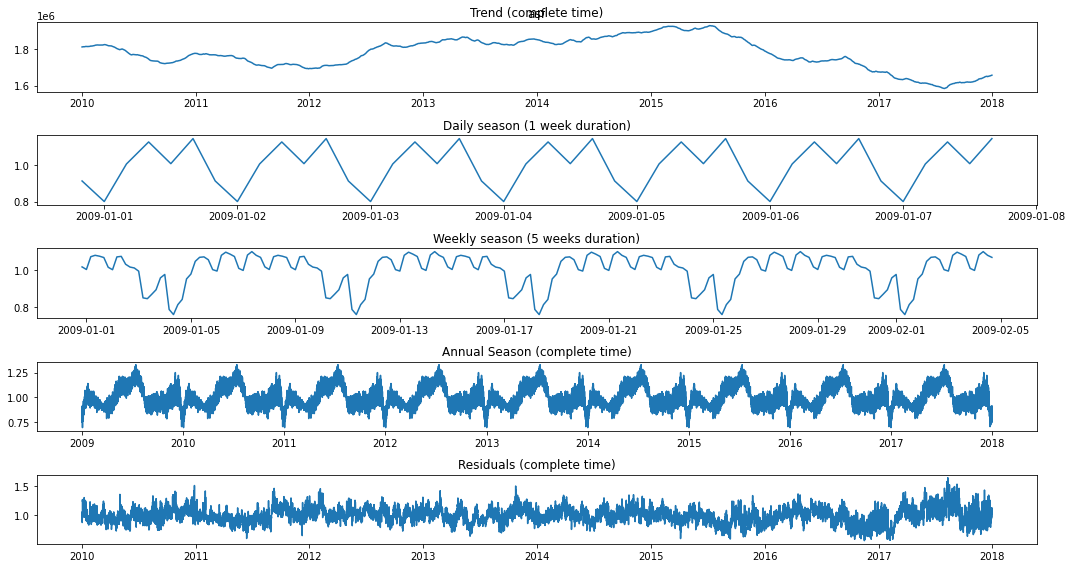

In [106]:
visualize_decomposition(a_p_isoliert, d_p_isoliert, w_p_isoliert)

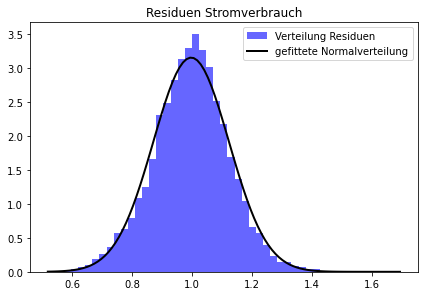

In [109]:
visualize_distribution(a_p_isoliert, norm)

### Additive Decomposition Strombudget Isoliert 4H Daten

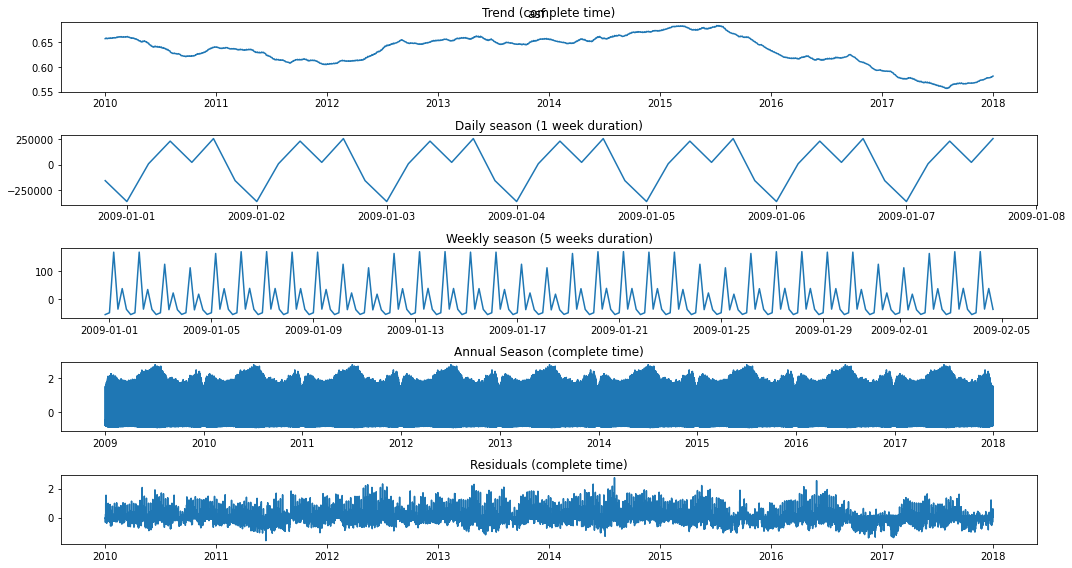

<Figure size 432x288 with 0 Axes>

In [116]:
visualize_decomposition(a_p_isoliert_add, d_p_isoliert_add, w_p_isoliert_add)

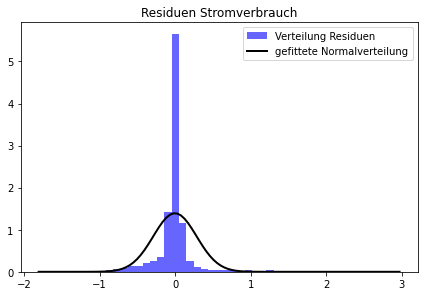

In [112]:
visualize_distribution(a_p_isoliert_add, norm)

### Multiplicative Decomposition Stromverbrauch Isoliert 4H Daten

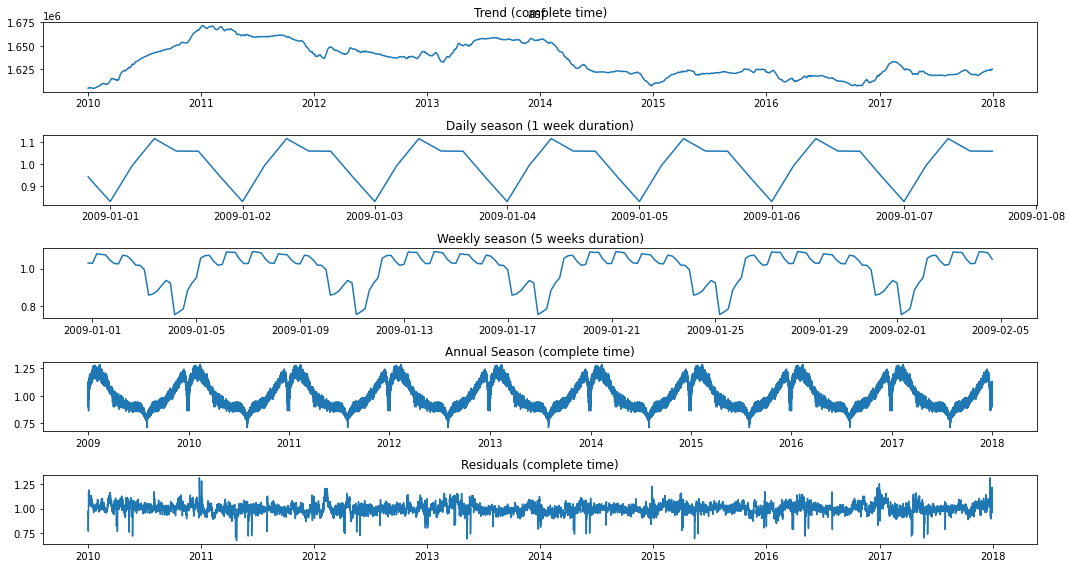

In [118]:
visualize_decomposition(a_v_isoliert, d_v_isoliert, w_v_isoliert)

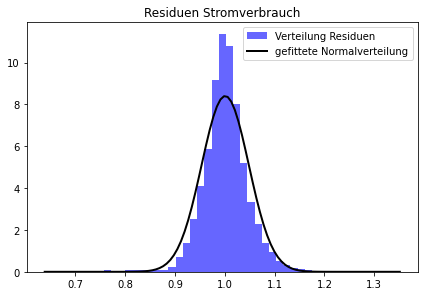

In [120]:
visualize_distribution(a_v_isoliert, norm)

### Additive Decomposition Stromverbrauch Isoliert 4H Daten

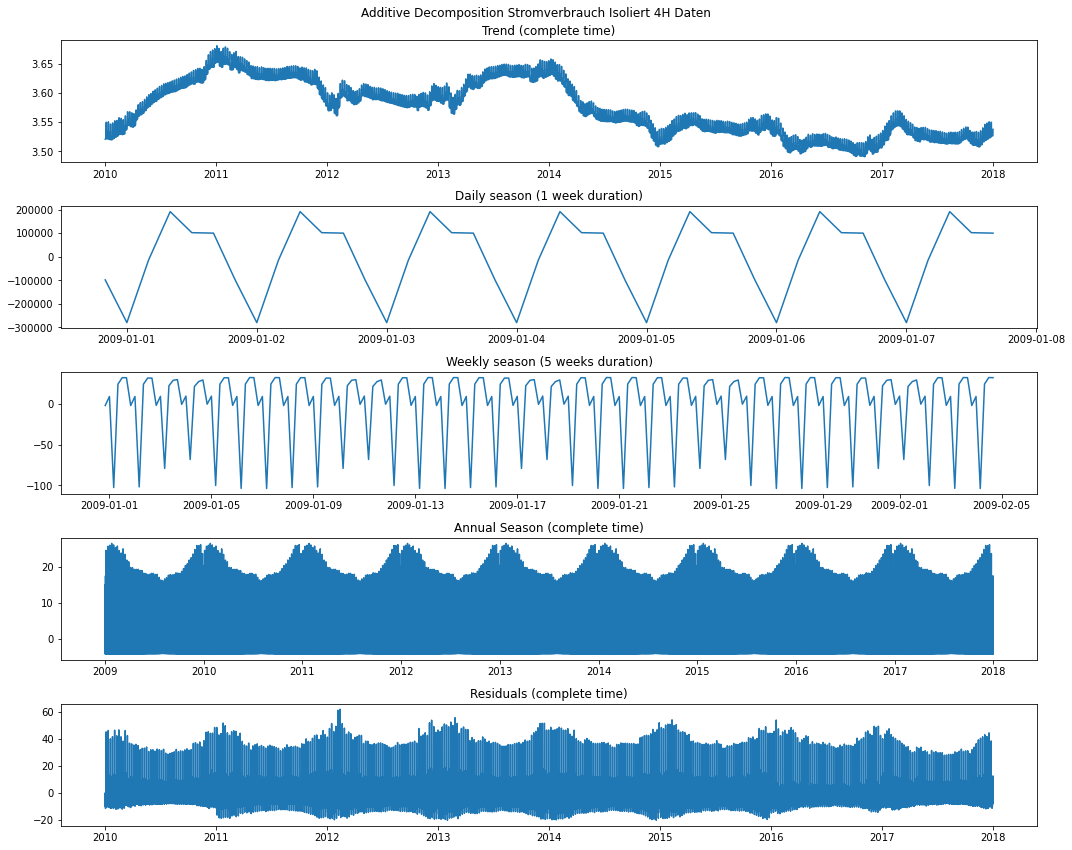

In [93]:
visualize_decomposition(a_v_isoliert_add, d_v_isoliert_add, w_v_isoliert_add)

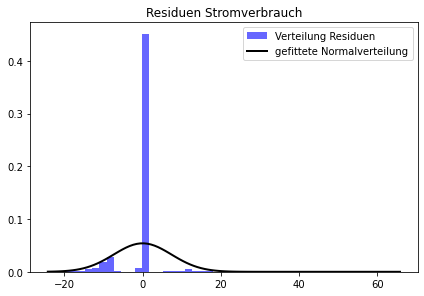

In [121]:
visualize_distribution(a_v_isoliert_add, norm)

### Multiplicative Decomposition Strombilanz Isoliert 4H Daten

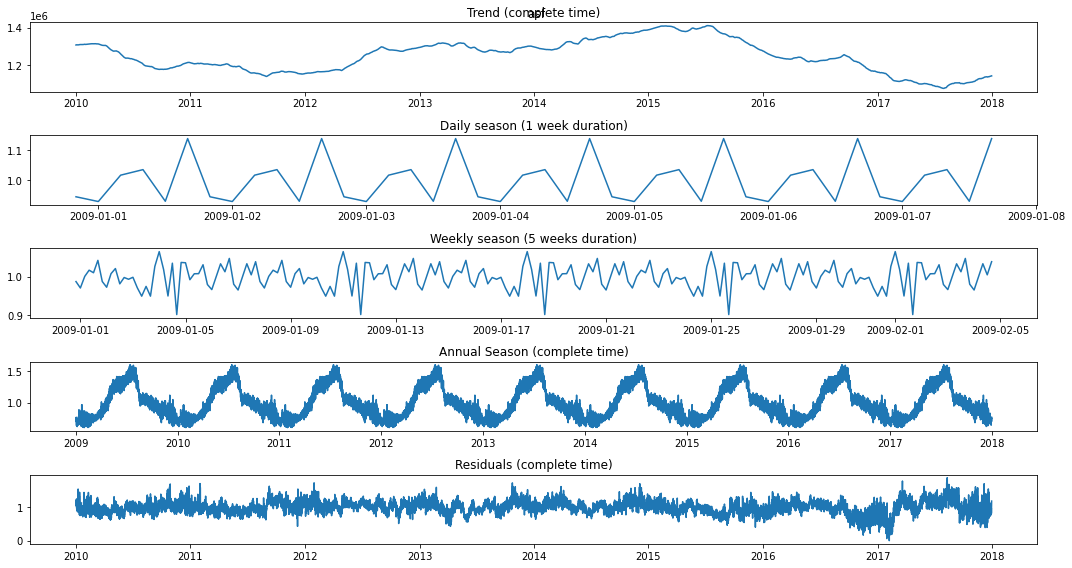

In [123]:
visualize_decomposition(a_b_isoliert, d_b_isoliert, w_b_isoliert)

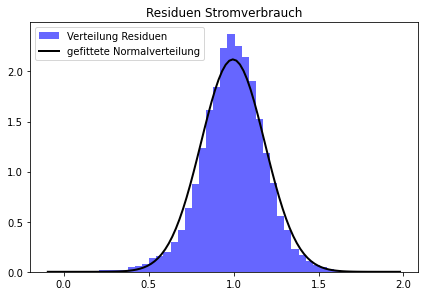

In [125]:
visualize_distribution(a_b_isoliert, norm)

### Additive Decomposition Strombilanz Isoliert 4H Daten

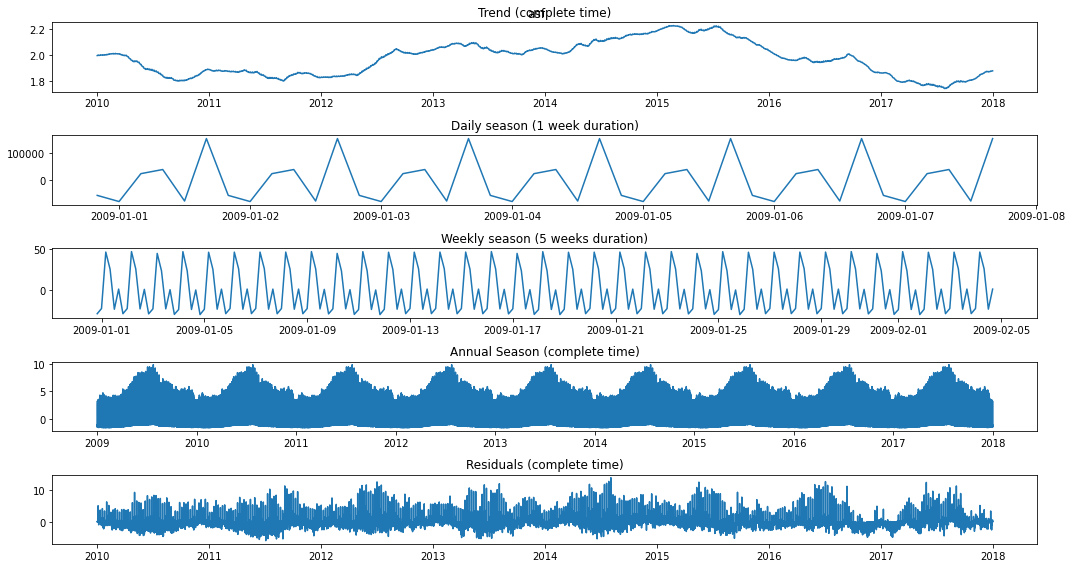

In [126]:
visualize_decomposition(a_b_isoliert_add, d_b_isoliert_add, w_b_isoliert_add)

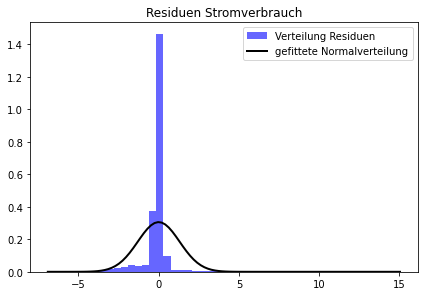

In [127]:
visualize_distribution(a_b_isoliert_add, norm)

### Diskussion zu den isolierten Daten:

In der multiplikativen Dekomposition gab es bei allen Daten eine gleichmässige Normalverteilung der Residuen (Normalverteilung mit Erwartungswert 0 und berechnbare Varianz). Bei den additiven scheinen die Residuen ganz wenig rechtsschief zu sein mit einem sehr sehr grossen Spitz bei Null. Heisst das, dass das additive Modell besser ist, weil es viel mehr Residuen bei 0 hat? Vielleicht ist der Error, der später berechnet wird, ausschlaggebender. 

## Solardaten:

### Multiplicative Decomposition Strombudget Solar 4H Daten

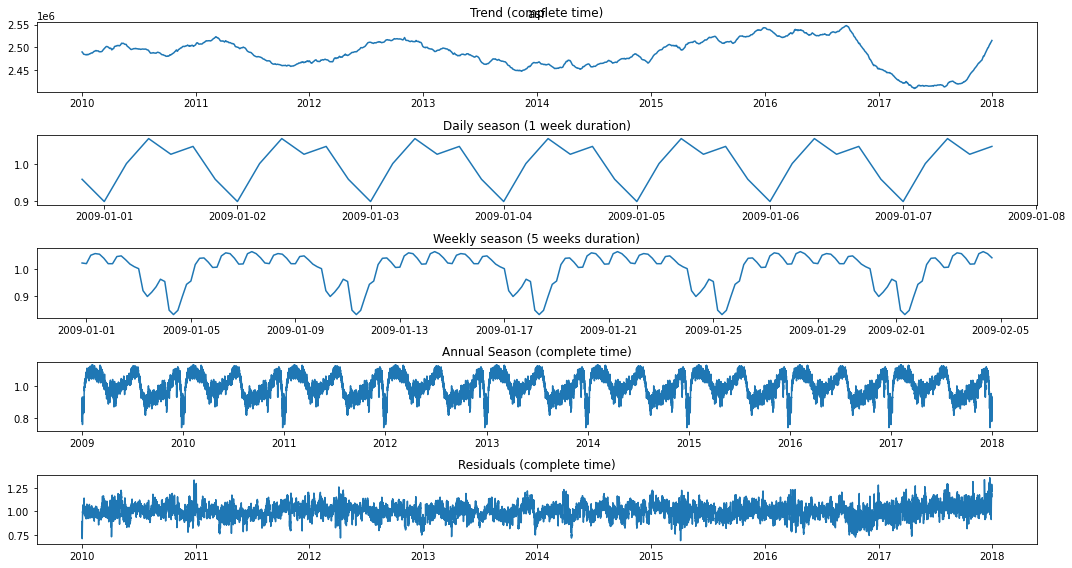

In [128]:
visualize_decomposition(a_p_solar, d_p_solar, w_p_solar)

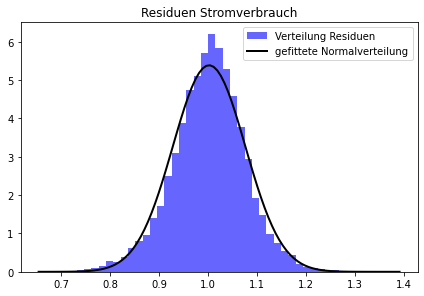

In [129]:
visualize_distribution(a_p_solar, norm)

### Additive Decomposition Strombudget Solar 4H Daten

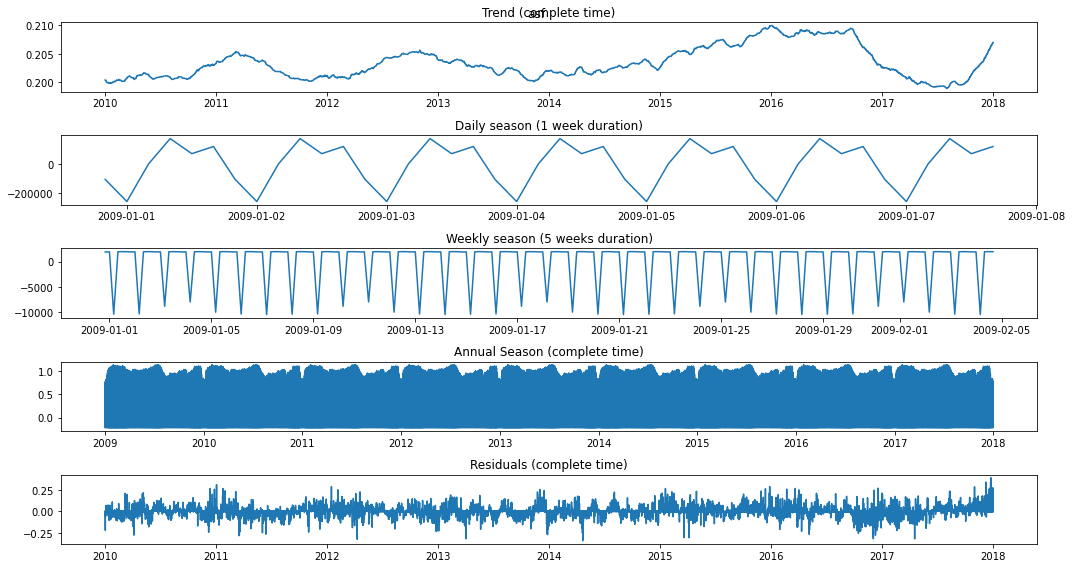

In [131]:
visualize_decomposition(a_p_solar_add, d_p_solar_add, w_p_solar_add)

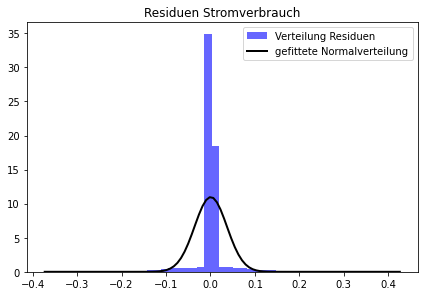

In [132]:
visualize_distribution(a_p_solar_add, norm)

### Multiplicative Decomposition Stromverbrauch Solar 4H Daten

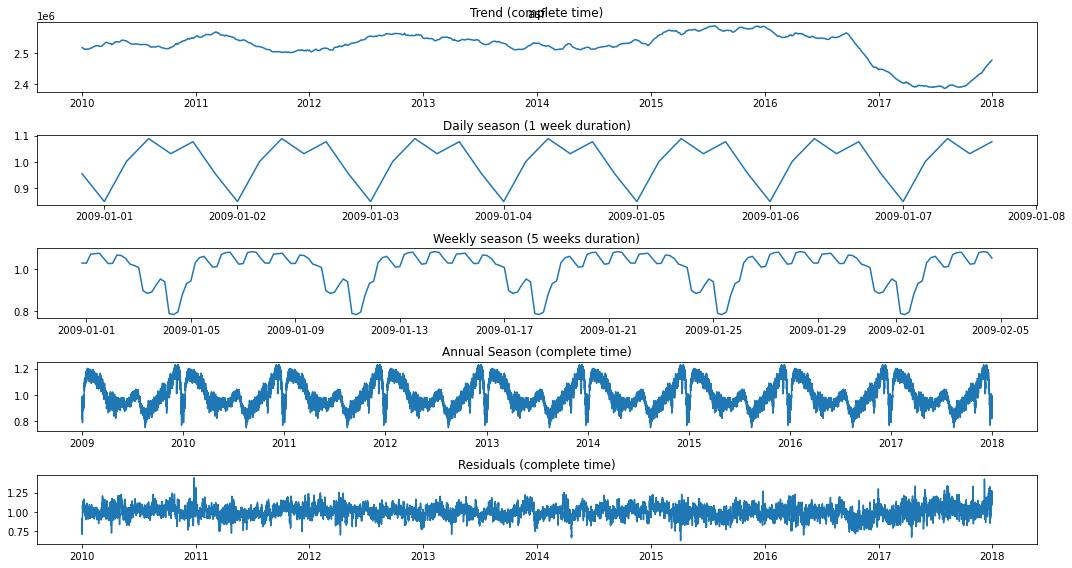

In [133]:
visualize_decomposition(a_v_solar, d_v_solar, w_v_solar)

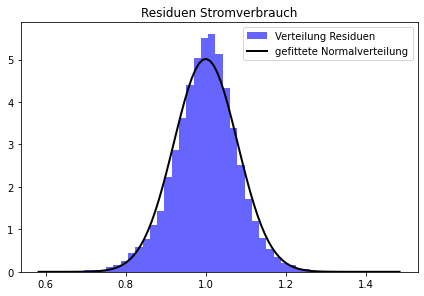

In [134]:
visualize_distribution(a_v_solar, norm)

### Additive Decomposition Stromverbrauch Solar 4H Daten

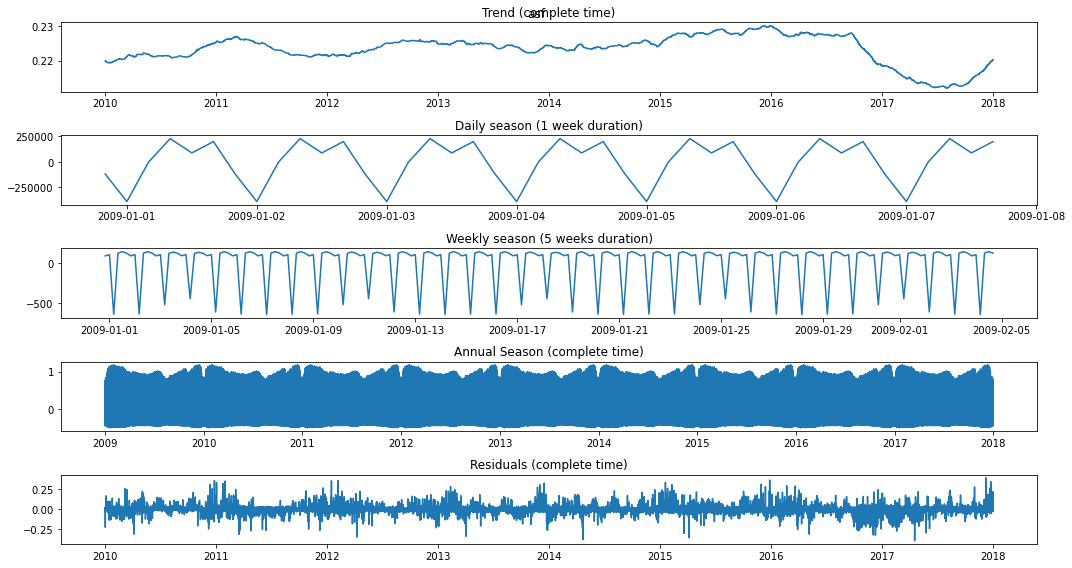

In [135]:
visualize_decomposition(a_v_solar_add, d_v_solar_add, w_v_solar_add)

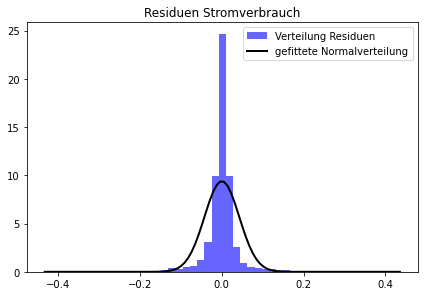

In [136]:
visualize_distribution(a_v_solar_add, norm)

### Multiplicative Decomposition Strombilanz Solar 4H Daten

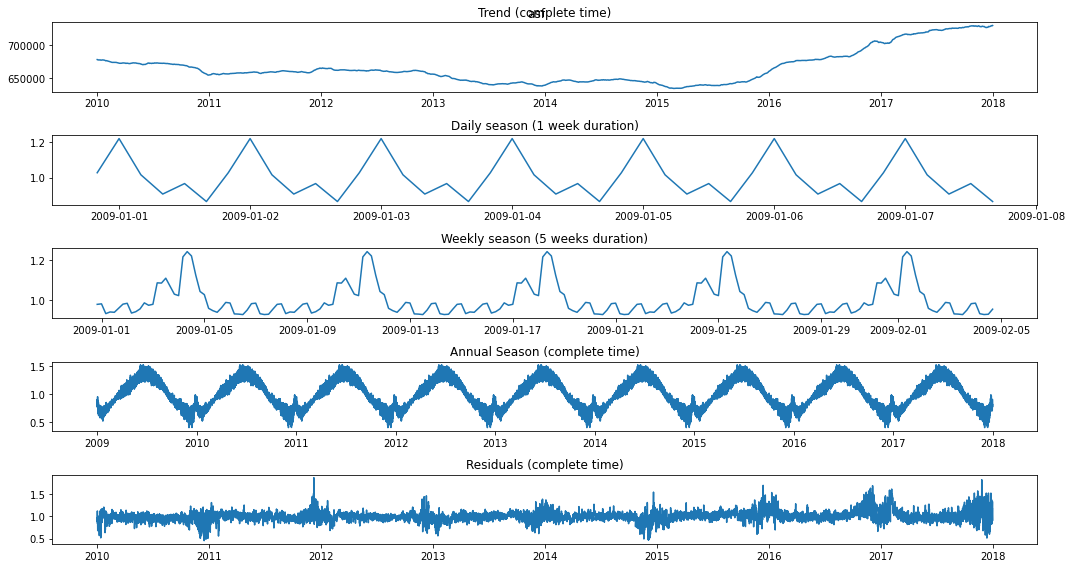

In [137]:
visualize_decomposition(a_b_solar, d_b_solar, w_b_solar)

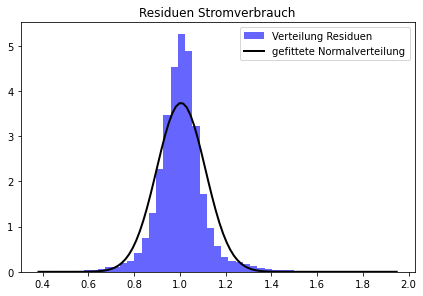

In [138]:
visualize_distribution(a_b_solar, norm)

### Additive Decomposition Strombilanz Solar 4H Daten

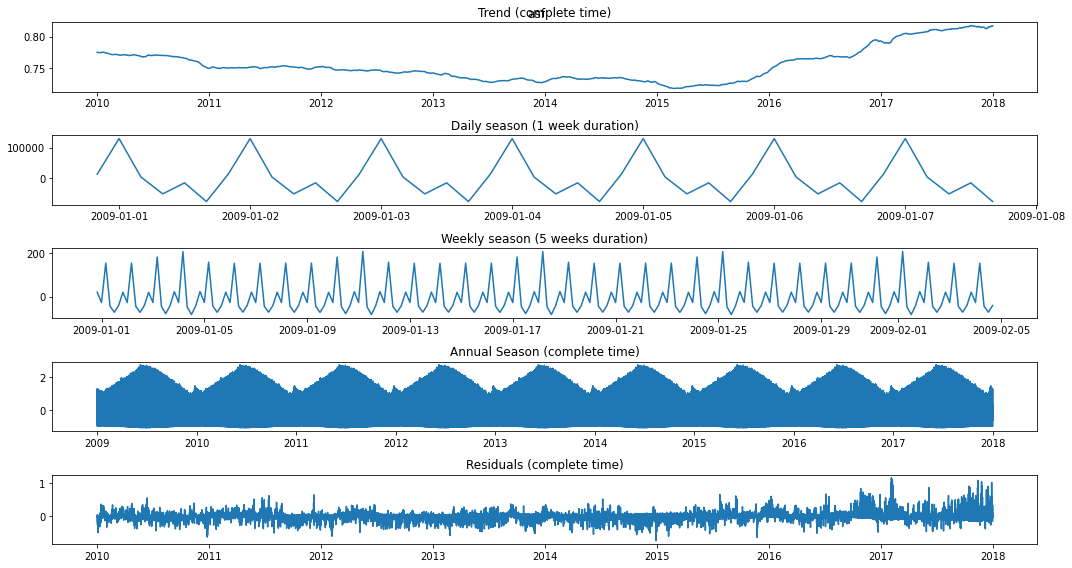

In [139]:
visualize_decomposition(a_b_solar_add, d_b_solar_add, w_b_solar_add)

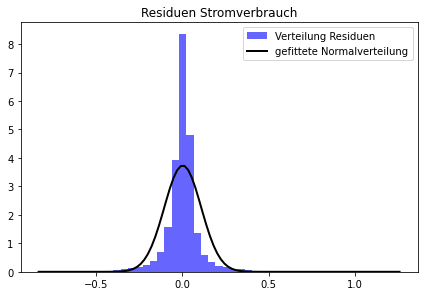

In [140]:
visualize_distribution(a_b_solar_add, norm)

### Diskussion

Eigentlich ist es das gleiche Spiel, wie bei den isolierten Daten. Die multiplikative Dekomposition ist eine sehr gut passende Normalverteilung, das additive Modell ist aber spiziger bei 0. Bei den Solardaten sind aber die Daten nicht rechtsschief oder linksschief sondern sehr schön zentriert.

## Rekonstruktionen

In [235]:
def reconstruct(data, reconstruct, title):
    plt.figure(figsize=(16,6))
    plt.plot(data, alpha=0.8, label="Original Series")
    plt.plot(reconstruct, alpha=0.8, label="Reconstructed")
    plt.legend()
    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel("kWH")
    plt.show()

    print("Mean avg percentage error:", mean_absolute_percentage_error(data, reconstruct))
    print("Mean absolute error:", mean_absolute_error(data, reconstruct))

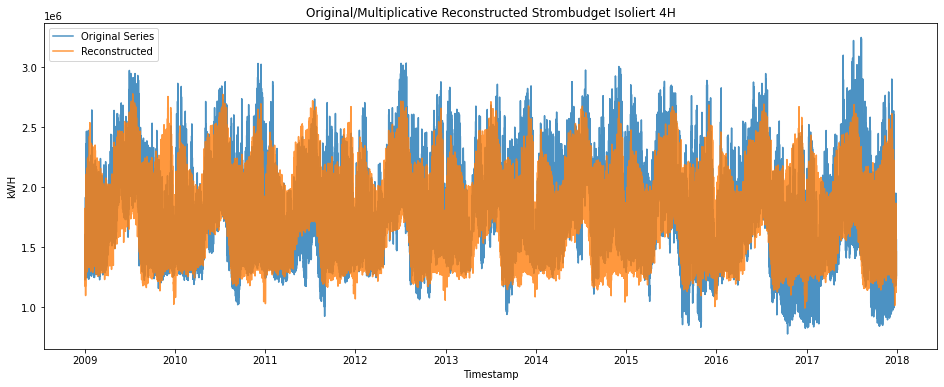

Mean avg percentage error: 0.1050441335414282
Mean absolute error: 177919.60142085614


In [236]:
reconstruct(data_4h_isoliert_train["Strombudget Schweiz"], reconstructed_p_isoliert, "Original/Multiplicative Reconstructed Strombudget Isoliert 4H")

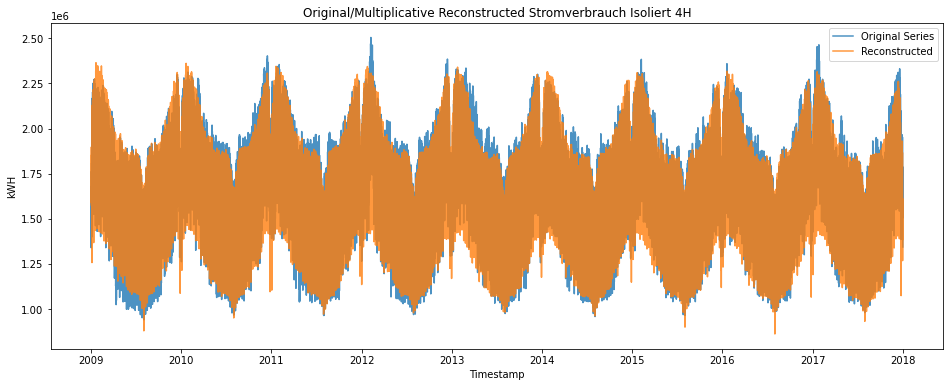

Mean avg percentage error: 0.03470714576025048
Mean absolute error: 55775.19098392054


In [202]:
reconstruct(data_4h_isoliert_train["Stromverbrauch Schweiz"], reconstructed_v_isoliert, "Original/Multiplicative Reconstructed Stromverbrauch Isoliert 4H")

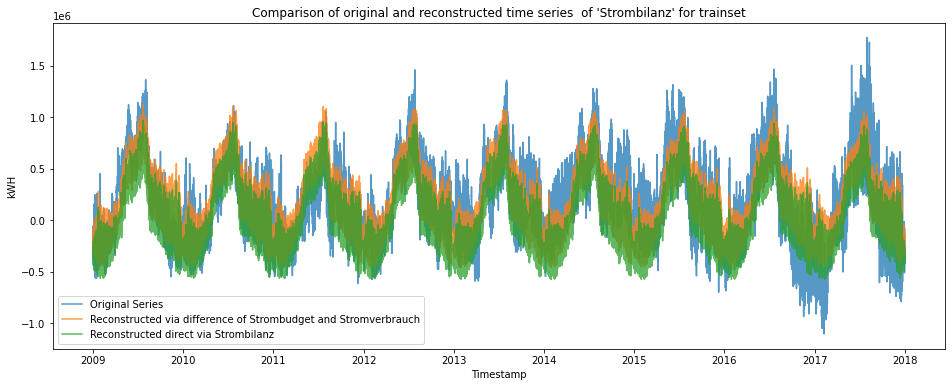


Comparison of Original & Reconstructed from 'Strombilanz'
Mean avg percentage error: 3.6779073015532213
Mean absolute error: 217511.86322548444
R2: 0.5468990908466589

Comparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 2.532096351655817
Mean absolute error: 177387.26571299497
R2: 0.6735832385322655

Comparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 2.6842493307936497
Mean absolute error: 144043.393996167
R2: 0.7996483181800612


In [246]:
plt.figure(figsize=(16,6))
plt.plot(data_4h_isoliert_train["Strombilanz Schweiz"], alpha=0.75, label="Original Series")
plt.plot(reconstructed_p_isoliert-reconstructed_v_isoliert, alpha=0.75, label="Reconstructed via difference of Strombudget and Stromverbrauch")
plt.plot(reconstructed_b_isoliert-reconstructed_b_isoliert.mean(), alpha=0.75, label="Reconstructed direct via Strombilanz")

plt.legend()
plt.title("Comparison of original and reconstructed time series  of 'Strombilanz' for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()


print("\nComparison of Original & Reconstructed from 'Strombilanz'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_b_isoliert-reconstructed_b_isoliert.mean()))
print("Mean absolute error:", mean_absolute_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_b_isoliert-reconstructed_b_isoliert.mean()))
print("R2:", r2_score(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_b_isoliert-reconstructed_b_isoliert.mean()))

print("\nComparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_p_isoliert-reconstructed_v_isoliert))
print("Mean absolute error:", mean_absolute_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_p_isoliert-reconstructed_v_isoliert))
print("R2:", r2_score(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_p_isoliert-reconstructed_v_isoliert))

print("\nComparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(reconstructed_b_isoliert-reconstructed_b_isoliert.mean(), reconstructed_p_isoliert-reconstructed_v_isoliert))
print("Mean absolute error:", mean_absolute_error(reconstructed_b_isoliert-reconstructed_b_isoliert.mean(), reconstructed_p_isoliert-reconstructed_v_isoliert))
print("R2:", r2_score(reconstructed_b_isoliert-reconstructed_b_isoliert.mean(), reconstructed_p_isoliert-reconstructed_v_isoliert))

(Wieso musste ich noch den mean abziehen der bilanz? Der Code ist gleich, wie bei main_normal.ipynb.)

Die Rekonstruktion der Bilanz durch den Unterschied zwischen der Rekonstruktionen des Verbrauchs und des Budgets sieht sehr ähnlich aus, wie die rekonstruierte Bilanz selber. Gleich, wie bei den Gesamtdaten. Die Rekonsturktion mit Budget - Verbrauch ist aber ein wenig besser.

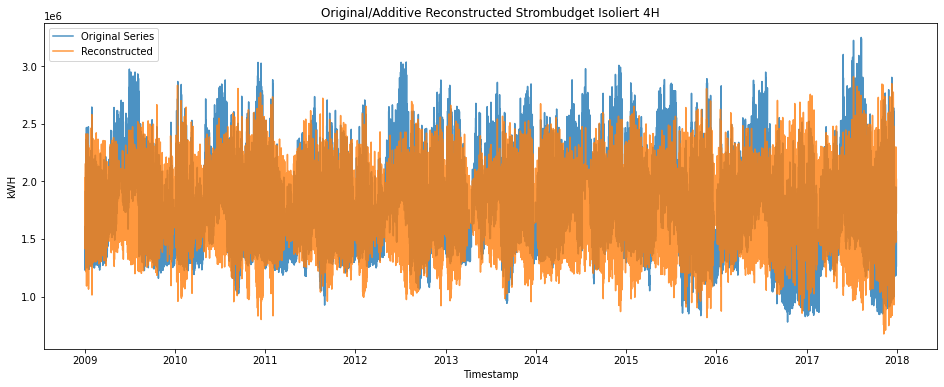

Mean avg percentage error: 0.14757253591655345
Mean absolute error: 243494.4992714823


In [224]:
reconstruct(data_4h_isoliert_train["Strombudget Schweiz"], 
            reconstructed_p_isoliert_add+data_4h_isoliert_train["Strombudget Schweiz"].mean(), 
            "Original/Additive Reconstructed Strombudget Isoliert 4H")

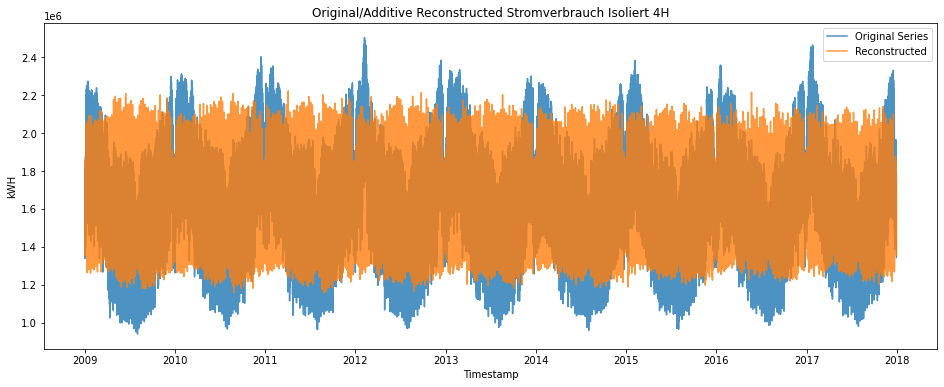

Mean avg percentage error: 0.11996380351831495
Mean absolute error: 188086.33347204071


In [225]:
reconstruct(data_4h_isoliert_train["Stromverbrauch Schweiz"], 
            reconstructed_v_isoliert_add+data_4h_isoliert_train["Stromverbrauch Schweiz"].mean(), 
            "Original/Additive Reconstructed Stromverbrauch Isoliert 4H")

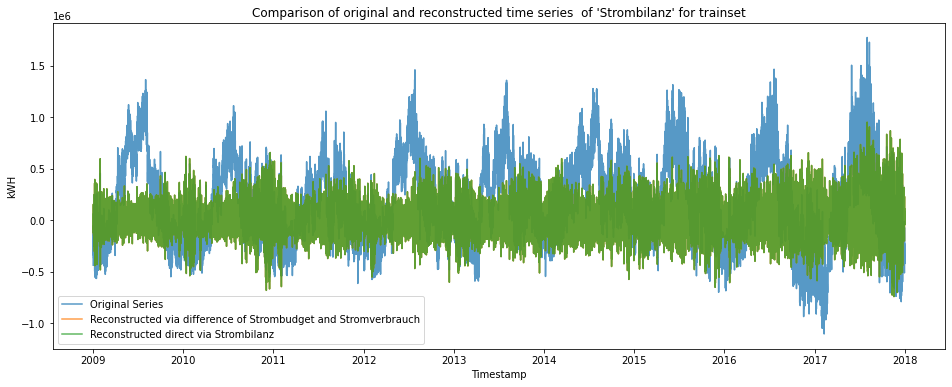


Comparison of Original & Reconstructed from 'Strombilanz'
Mean avg percentage error: 2.417652939386274
Mean absolute error: 306598.7623500641
R2: 0.01762159428040766

Comparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 2.4184595531009827
Mean absolute error: 306598.9878590123
R2: 0.017614684901837263

Comparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 0.004696064639665698
Mean absolute error: 80.82388842150229
R2: 0.9999996164287991


In [249]:
plt.figure(figsize=(16,6))
plt.plot(data_4h_isoliert_train["Strombilanz Schweiz"], alpha=0.75, label="Original Series")
plt.plot(reconstructed_p_isoliert_add-reconstructed_v_isoliert_add, alpha=0.75, label="Reconstructed via difference of Strombudget and Stromverbrauch")
plt.plot(reconstructed_b_isoliert_add, alpha=0.75, label="Reconstructed direct via Strombilanz")

plt.legend()
plt.title("Comparison of original and reconstructed time series  of 'Strombilanz' for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()


print("\nComparison of Original & Reconstructed from 'Strombilanz'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_b_isoliert_add))
print("Mean absolute error:", mean_absolute_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_b_isoliert_add))
print("R2:", r2_score(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_b_isoliert_add))

print("\nComparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_p_isoliert_add-reconstructed_v_isoliert_add))
print("Mean absolute error:", mean_absolute_error(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_p_isoliert_add-reconstructed_v_isoliert_add))
print("R2:", r2_score(data_4h_isoliert_train["Strombilanz Schweiz"], reconstructed_p_isoliert_add-reconstructed_v_isoliert_add))

print("\nComparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(reconstructed_b_isoliert_add, reconstructed_p_isoliert_add-reconstructed_v_isoliert_add))
print("Mean absolute error:", mean_absolute_error(reconstructed_b_isoliert_add, reconstructed_p_isoliert_add-reconstructed_v_isoliert_add))
print("R2:", r2_score(reconstructed_b_isoliert_add, reconstructed_p_isoliert_add-reconstructed_v_isoliert_add))

### Solar

Das additive Modell ist bei der Rekonstruktion der Bilanz schlechter und es gibt keinen Unterschied zwischen Budget - Verbrauch oder direkter Bilanz.

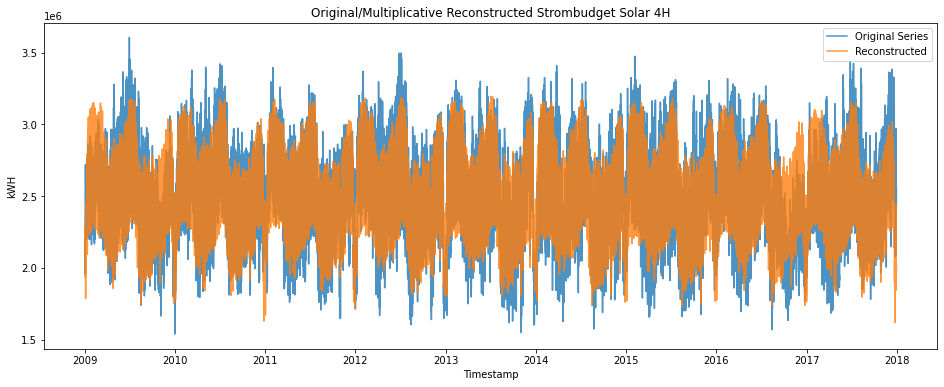

Mean avg percentage error: 0.057909101985489916
Mean absolute error: 140672.8401975687


In [250]:
reconstruct(data_4h_solar_train["Strombudget Schweiz"], reconstructed_p_solar, "Original/Multiplicative Reconstructed Strombudget Solar 4H")

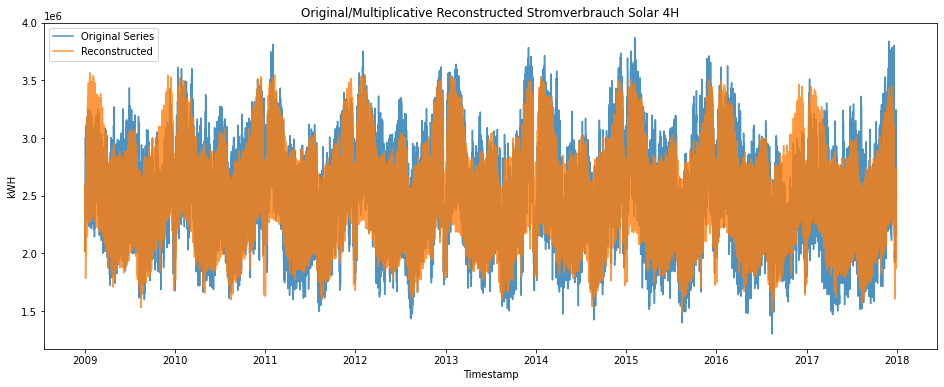

Mean avg percentage error: 0.063150942712783
Mean absolute error: 155424.9716282111


In [251]:
reconstruct(data_4h_solar_train["Stromverbrauch Schweiz"], reconstructed_v_solar, "Original/Multiplicative Reconstructed Stromverbrauch Solar 4H")

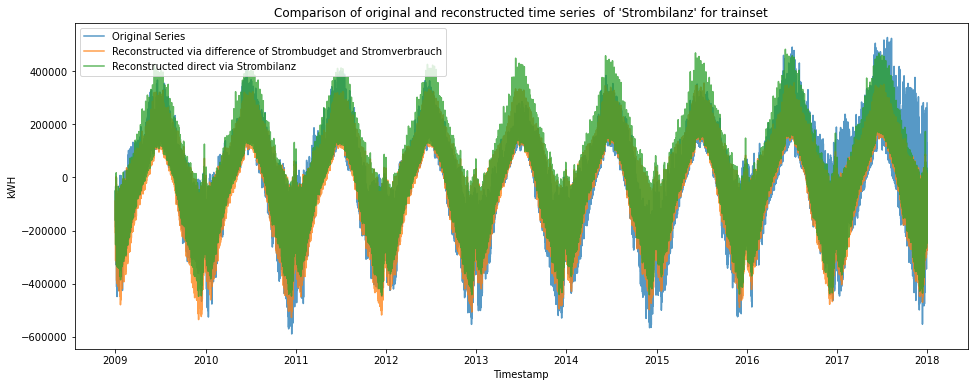


Comparison of Original & Reconstructed from 'Strombilanz'
Mean avg percentage error: 2.93288038635227
Mean absolute error: 55148.186798809074
R2: 0.852131664698938

Comparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 1.9546998152415782
Mean absolute error: 45214.13575637764
R2: 0.8926937150577735

Comparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 1.8544435415431886
Mean absolute error: 37516.01145651598
R2: 0.939959467905412


In [252]:
plt.figure(figsize=(16,6))
plt.plot(data_4h_solar_train["Strombilanz Schweiz"], alpha=0.75, label="Original Series")
plt.plot(reconstructed_p_solar-reconstructed_v_solar, alpha=0.75, label="Reconstructed via difference of Strombudget and Stromverbrauch")
plt.plot(reconstructed_b_solar-reconstructed_b_solar.mean(), alpha=0.75, label="Reconstructed direct via Strombilanz")

plt.legend()
plt.title("Comparison of original and reconstructed time series  of 'Strombilanz' for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()


print("\nComparison of Original & Reconstructed from 'Strombilanz'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_b_solar-reconstructed_b_solar.mean()))
print("Mean absolute error:", mean_absolute_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_b_solar-reconstructed_b_solar.mean()))
print("R2:", r2_score(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_b_solar-reconstructed_b_solar.mean()))

print("\nComparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_p_solar-reconstructed_v_solar))
print("Mean absolute error:", mean_absolute_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_p_solar-reconstructed_v_solar))
print("R2:", r2_score(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_p_solar-reconstructed_v_solar))

print("\nComparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(reconstructed_b_solar-reconstructed_b_solar.mean(), reconstructed_p_solar-reconstructed_v_solar))
print("Mean absolute error:", mean_absolute_error(reconstructed_b_solar-reconstructed_b_solar.mean(), reconstructed_p_solar-reconstructed_v_solar))
print("R2:", r2_score(reconstructed_b_solar-reconstructed_b_solar.mean(), reconstructed_p_solar-reconstructed_v_solar))

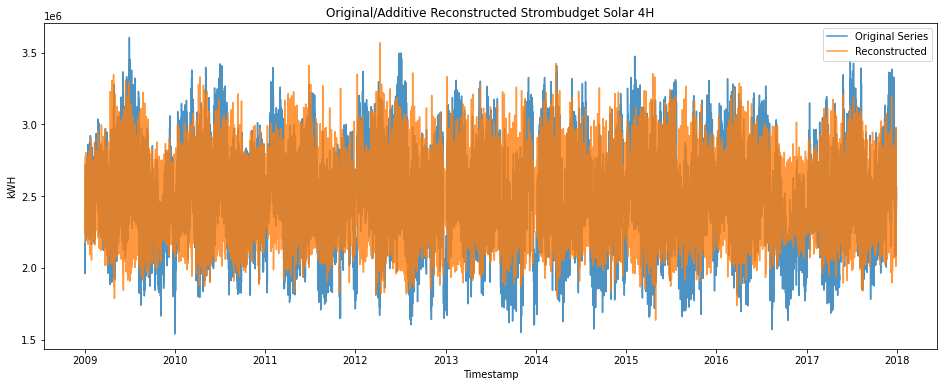

Mean avg percentage error: 0.08962979470415201
Mean absolute error: 214349.6010459229


In [255]:
reconstruct(data_4h_solar_train["Strombudget Schweiz"], 
            reconstructed_p_solar_add+data_4h_solar_train["Strombudget Schweiz"].mean(), 
            "Original/Additive Reconstructed Strombudget Solar 4H")

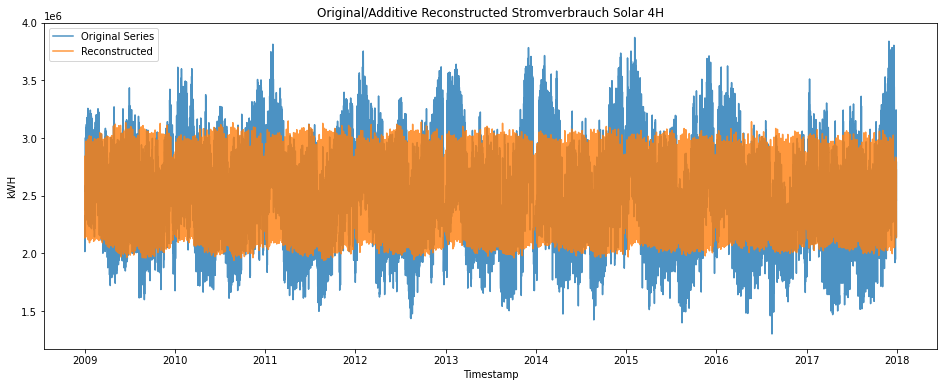

Mean avg percentage error: 0.11729634838803647
Mean absolute error: 282483.3389331186


In [256]:
reconstruct(data_4h_solar_train["Stromverbrauch Schweiz"], 
            reconstructed_v_solar_add+data_4h_solar_train["Stromverbrauch Schweiz"].mean(), 
            "Original/Additive Reconstructed Stromverbrauch Solar 4H")

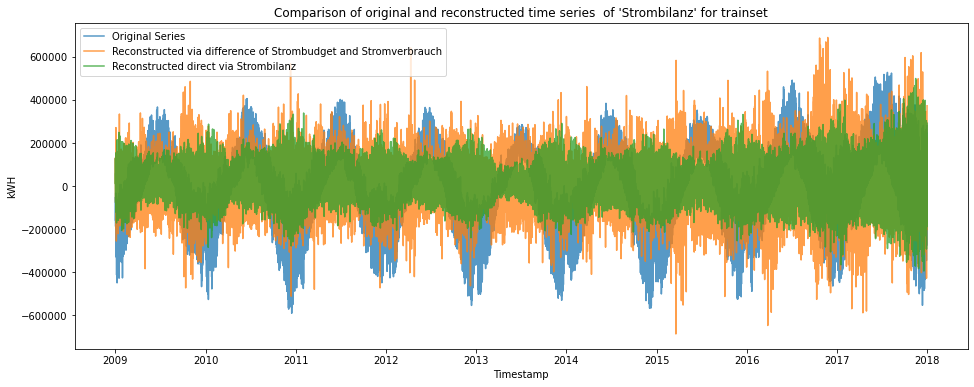


Comparison of Original & Reconstructed from 'Strombilanz'
Mean avg percentage error: 3.2999883213816936
Mean absolute error: 142749.22286366185
R2: 0.17569935432507489

Comparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 6.872843806341128
Mean absolute error: 169607.18847427965
R2: -0.2570089302710463

Comparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 6.593687444030665
Mean absolute error: 92848.17913955793
R2: -13.701410232167316


In [257]:
plt.figure(figsize=(16,6))
plt.plot(data_4h_solar_train["Strombilanz Schweiz"], alpha=0.75, label="Original Series")
plt.plot(reconstructed_p_solar_add-reconstructed_v_solar_add, alpha=0.75, label="Reconstructed via difference of Strombudget and Stromverbrauch")
plt.plot(reconstructed_b_solar_add-reconstructed_b_solar_add.mean(), alpha=0.75, label="Reconstructed direct via Strombilanz")

plt.legend()
plt.title("Comparison of original and reconstructed time series  of 'Strombilanz' for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()


print("\nComparison of Original & Reconstructed from 'Strombilanz'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_b_solar_add-reconstructed_b_solar_add.mean()))
print("Mean absolute error:", mean_absolute_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_b_solar_add-reconstructed_b_solar_add.mean()))
print("R2:", r2_score(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_b_solar_add-reconstructed_b_solar_add.mean()))

print("\nComparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_p_solar_add-reconstructed_v_solar_add))
print("Mean absolute error:", mean_absolute_error(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_p_solar_add-reconstructed_v_solar_add))
print("R2:", r2_score(data_4h_solar_train["Strombilanz Schweiz"], reconstructed_p_solar_add-reconstructed_v_solar_add))

print("\nComparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(reconstructed_b_solar_add-reconstructed_b_solar_add.mean(), reconstructed_p_solar_add-reconstructed_v_solar_add))
print("Mean absolute error:", mean_absolute_error(reconstructed_b_solar_add-reconstructed_b_solar_add.mean(), reconstructed_p_solar_add-reconstructed_v_solar_add))
print("R2:", r2_score(reconstructed_b_solar-reconstructed_b_solar_add.mean(), reconstructed_p_solar_add-reconstructed_v_solar_add))

Bei den Solardaten ist auch wieder das Modell mit der Differenz zwischen Budget und Verbrauch besser und das multiplikative Modell hat auch bessere R2 Scores.

## Testset

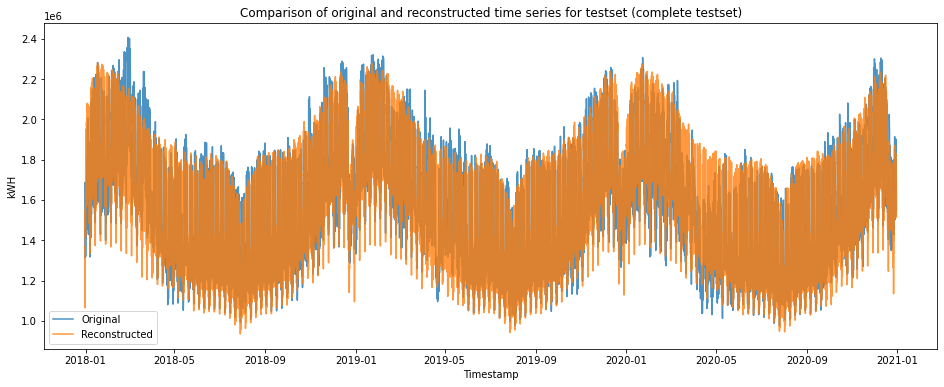

Mean avg percentage error: 0.04134988544188559
Mean absolute error: 65335.67724144691
R2: 0.8967855055269249


In [273]:
plt.figure(figsize=(16,6))
next_3y_pred_isoliert = df_re_v_isoliert["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
next_3y_is_isoliert = data_4h_isoliert_test["Stromverbrauch Schweiz"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
plt.plot(next_3y_is_isoliert, alpha=0.8, label="Original")
plt.plot(next_3y_pred_isoliert+next_3y_is_isoliert.mean()-next_3y_pred_isoliert.mean(), alpha=0.8, label="Reconstructed")
plt.title("Comparison of original and reconstructed time series for testset (complete testset)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_pred_isoliert+next_3y_is_isoliert.mean()-next_3y_pred_isoliert.mean(), next_3y_is_isoliert))
print("Mean absolute error:", mean_absolute_error(next_3y_pred_isoliert+next_3y_is_isoliert.mean()-next_3y_pred_isoliert.mean(), next_3y_is_isoliert))
print("R2:", r2_score(next_3y_pred_isoliert+next_3y_is_isoliert.mean()-next_3y_pred_isoliert.mean(), next_3y_is_isoliert))

Generelle Verteilung wird gut rekonstruiert.

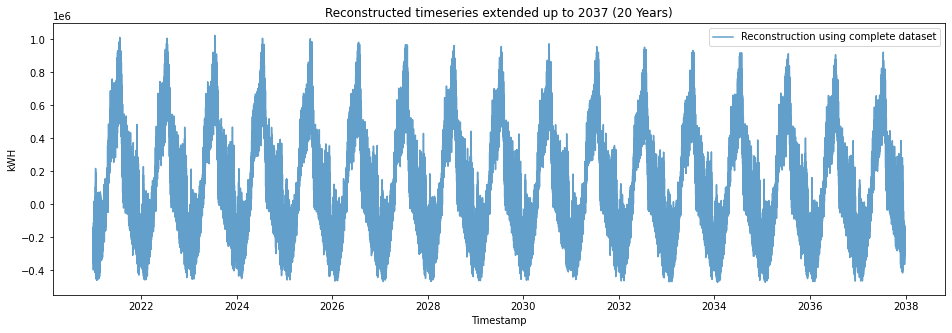

'print("Mean avg percentage error:", mean_absolute_percentage_error(balance_20y_total[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\'], \n                                                                   balance_20y[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\']))\nprint("Mean absolute error:", mean_absolute_error(balance_20y_total[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\'], \n                                                  balance_20y[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\']))\nprint("R2:", r2_score(balance_20y_total[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\'], \n                        balance_20y[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\']))'

In [279]:
balance_20y_isoliert = df_re_p_isoliert["reconstructed"] - df_re_v_isoliert["reconstructed"]


plt.figure(figsize=(16,5))
plt.title("Reconstructed timeseries extended up to 2037 (20 Years)")
plt.plot(balance_20y_isoliert['2020-12-31 00:00:00+00:00':'2040-12-31 00:00:00+00:00'], alpha=0.7,
         label="Reconstruction using complete dataset")
#plt.plot(balance_20y['2020-12-31 00:00:00+00:00':'2040-12-31 00:00:00+00:00'], alpha=0.7,
#         label="Reconstruction using trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

"""print("Mean avg percentage error:", mean_absolute_percentage_error(balance_20y_total['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00'], 
                                                                   balance_20y['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00']))
print("Mean absolute error:", mean_absolute_error(balance_20y_total['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00'], 
                                                  balance_20y['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00']))
print("R2:", r2_score(balance_20y_total['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00'], 
                        balance_20y['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00']))"""

Bei den isolierten Daten wird eine recht stationäre Zeitreihe vorhergesagt mit stark definierten Highs und Lows.

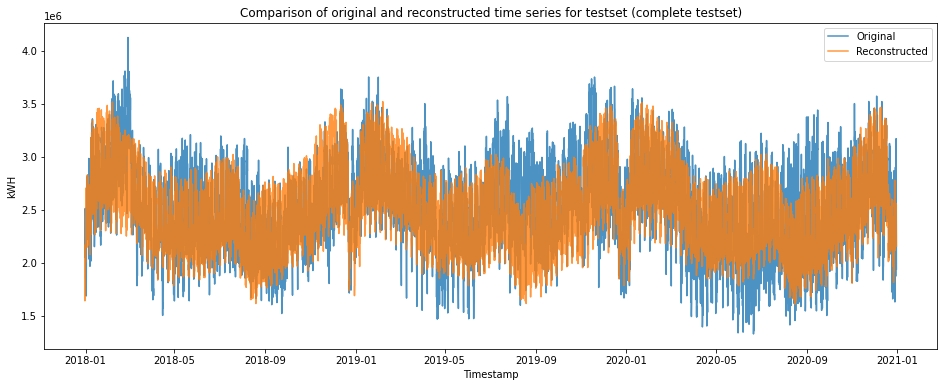

Mean avg percentage error: 0.08085855507461827
Mean absolute error: 86932.16031273134
R2: -9.083705085990912


In [276]:
plt.figure(figsize=(16,6))
next_3y_pred_solar = df_re_v_solar["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
next_3y_is_solar = data_4h_solar_test["Stromverbrauch Schweiz"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
plt.plot(next_3y_is_solar, alpha=0.8, label="Original")
plt.plot(next_3y_pred_solar+next_3y_is_solar.mean()-next_3y_pred_solar.mean(), alpha=0.8, label="Reconstructed")
plt.title("Comparison of original and reconstructed time series for testset (complete testset)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_pred_solar+next_3y_is_solar.mean()-next_3y_pred_solar.mean(), next_3y_is_solar))
print("Mean absolute error:", mean_absolute_error(next_3y_pred_isoliert+next_3y_is_solar.mean()-next_3y_pred_solar.mean(), next_3y_is_isoliert))
print("R2:", r2_score(next_3y_pred_isoliert+next_3y_is_solar.mean()-next_3y_pred_solar.mean(), next_3y_is_solar))

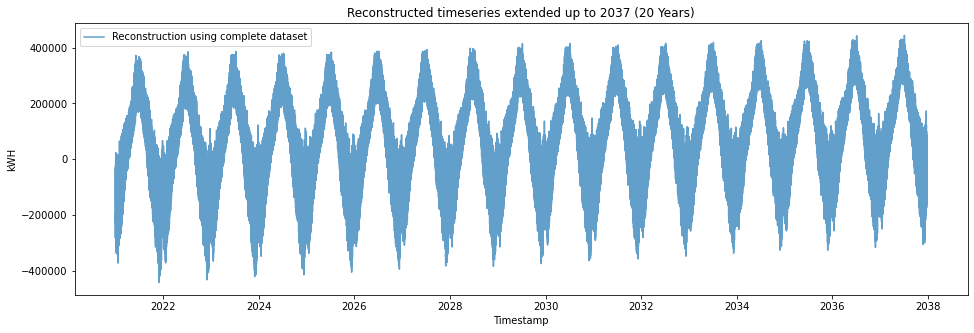

'print("Mean avg percentage error:", mean_absolute_percentage_error(balance_20y_total[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\'], \n                                                                   balance_20y[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\']))\nprint("Mean absolute error:", mean_absolute_error(balance_20y_total[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\'], \n                                                  balance_20y[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\']))\nprint("R2:", r2_score(balance_20y_total[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\'], \n                        balance_20y[\'2020-12-31 00:00:00+00:00\':\'2039-12-31 00:00:00+00:00\']))'

In [280]:
balance_20y_solar = df_re_p_solar["reconstructed"] - df_re_v_solar["reconstructed"]


plt.figure(figsize=(16,5))
plt.title("Reconstructed timeseries extended up to 2037 (20 Years)")
plt.plot(balance_20y_solar['2020-12-31 00:00:00+00:00':'2040-12-31 00:00:00+00:00'], alpha=0.7,
         label="Reconstruction using complete dataset")
#plt.plot(balance_20y['2020-12-31 00:00:00+00:00':'2040-12-31 00:00:00+00:00'], alpha=0.7,
#         label="Reconstruction using trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

"""print("Mean avg percentage error:", mean_absolute_percentage_error(balance_20y_total['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00'], 
                                                                   balance_20y['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00']))
print("Mean absolute error:", mean_absolute_error(balance_20y_total['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00'], 
                                                  balance_20y['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00']))
print("R2:", r2_score(balance_20y_total['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00'], 
                        balance_20y['2020-12-31 00:00:00+00:00':'2039-12-31 00:00:00+00:00']))"""

Bei den Solardaten erkennts eine schwache Steigung. Wie bei den isolierten Daten auch wieder grosse Highs und Lows. Nicht so, wie bei den Gesamtdaten. Das könnte man auch erwarten, weil erneuerbare Energien mit der Zeit den gwöhnlichen Methoden mehr Konkurrenz bieten. Der Trend wird aber wahrscheinlich nicht so linear sein. 

In [295]:
df_v = balance_20y_isoliert['2020-12-31 00:00:00+00:00':'2040-12-31 00:00:00+00:00']-(balance_20y_isoliert.min()-1)

# daily season
d_v = seasonal_decompose(df_v, period=6, model="multiplicative", two_sided=False)
r_v = df_v / d_v.seasonal
# monthly season
w_v = seasonal_decompose(r_v, period=6*7, model="multiplicative", two_sided=False)
r_v = r_v / w_v.seasonal
# annual season
a_v = seasonal_decompose(r_v, period=6*365, model="multiplicative", two_sided=False)
r_v = r_v / a_v.seasonal

#perform augmented Dickey-Fuller test
print("ADFULLER ISOLIERT:")
adfuller(a_v.trend.dropna())

ADFULLER ISOLIERT:


(-0.39642154270403696,
 0.91069453929069,
 51,
 34983,
 {'1%': -3.4305369416544598,
  '5%': -2.8616226235903994,
  '10%': -2.566813977940604},
 162400.3602379468)

In [289]:
df_v = balance_20y_solar['2020-12-31 00:00:00+00:00':'2040-12-31 00:00:00+00:00']-(balance_20y_solar.min()-1)

# daily season
d_v = seasonal_decompose(df_v, period=6, model="multiplicative", two_sided=False)
r_v = df_v / d_v.seasonal
# monthly season
w_v = seasonal_decompose(r_v, period=6*7, model="multiplicative", two_sided=False)
r_v = r_v / w_v.seasonal
# annual season
a_v = seasonal_decompose(r_v, period=6*365, model="multiplicative", two_sided=False)
r_v = r_v / a_v.seasonal

#perform augmented Dickey-Fuller test
print("ADFULLER SOLAR:")
adfuller(a_v.trend.dropna())

ADFULLER SOLAR:


(-1.0478016817525946,
 0.7354331661305055,
 52,
 34982,
 {'1%': -3.43053694699879,
  '5%': -2.861622625952387,
  '10%': -2.5668139791978284},
 104692.65608561265)

Beide, Solar und Isoliert, sind nicht stationär laut dem ADFuller-Test.

## ARIMA Modell

In [297]:
data_m_isoliert_train, data_m_isoliert_test = data_m_isoliert[:'2017-12-31 00:00:00+00:00'], data_m_isoliert['2017-12-31 00:00:00+00:00':]
data_m_solar_train, data_m_solar_test = data_m_solar[:'2017-12-31 00:00:00+00:00'], data_m_solar['2017-12-31 00:00:00+00:00':]

In [335]:
arima_m_p_isoliert = ARIMA(data_m_isoliert_train["Strombudget Schweiz"], order=(3, 1, 3), seasonal_order=(2,1,1,12)).fit()
arima_m_v_isoliert = ARIMA(data_m_isoliert_train["Stromverbrauch Schweiz"], order=(7, 0, 3), seasonal_order=(2,1,1,12)).fit()
arima_m_b_isoliert = ARIMA(data_m_isoliert_train["Strombilanz Schweiz"], order=(5, 0, 3), seasonal_order=(2,1,2,12)).fit()
arima_m_b_isoliert_diff = ARIMA(data_m_isoliert_train["Strombudget Schweiz"]-data_m_isoliert_train["Stromverbrauch Schweiz"], order=(5, 0, 3), seasonal_order=(2,1,2,12)).fit()

Die Parameter wurden aus dem ACF und PACF genommen. Es gibt hier sicher noch mehr Spielraum. Beim anpassen der Parameter der Budgets war das Setzen der 1 in 3,1,3 auch ausschlaggebend, dass der MAE sank. 

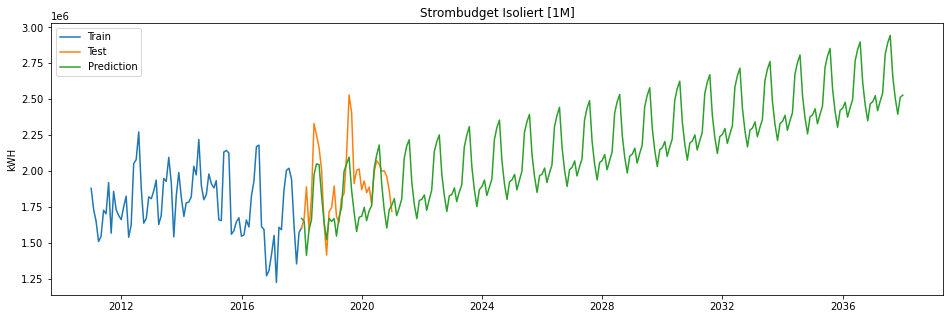

Mean avg percentage error: 0.09745365975763158
Mean absolute error: 169606.238092521


In [321]:
pred_p_isoliert = arima_m_p_isoliert.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Strombudget Isoliert [1M]')
plt.plot(data_m_isoliert_train["Strombudget Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_isoliert_test["Strombudget Schweiz"], label="Test")
plt.plot(pred_p_isoliert, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_p_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Strombudget Schweiz"]))
print("Mean absolute error:", mean_absolute_error(pred_p_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Strombudget Schweiz"]))

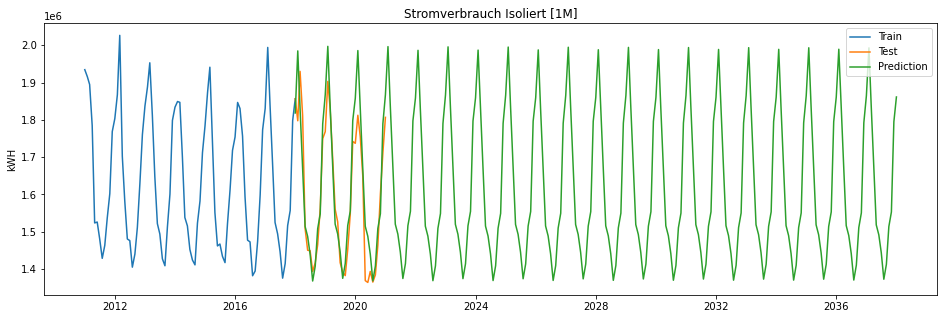

Mean avg percentage error: 0.0338400085252495
Mean absolute error: 57390.46628664339


In [323]:
pred_v_isoliert = arima_m_v_isoliert.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Stromverbrauch Isoliert [1M]')
plt.plot(data_m_isoliert_train["Stromverbrauch Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_isoliert_test["Stromverbrauch Schweiz"], label="Test")
plt.plot(pred_v_isoliert, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_v_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Stromverbrauch Schweiz"]))
print("Mean absolute error:", mean_absolute_error(pred_v_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Stromverbrauch Schweiz"]))

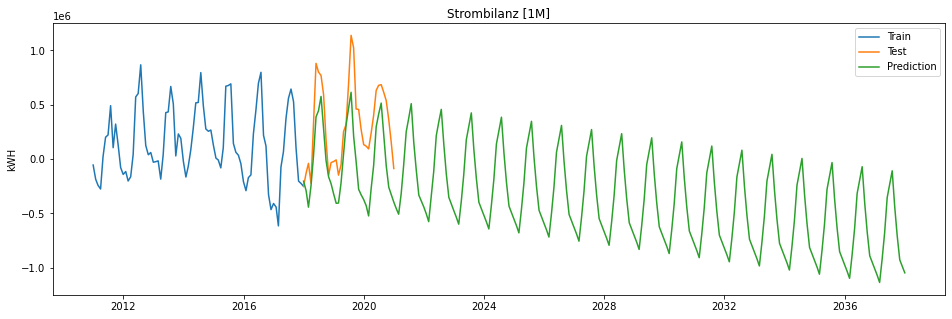

Mean avg percentage error (Test Set bis 2020): 2.8287823456369527
Mean absolute error (Test Set bis 2020): 356846.74873727537


In [325]:
pred_b_isoliert = arima_m_b_isoliert.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Strombilanz Isoliert [1M]')
plt.plot(data_m_isoliert_train["Strombilanz Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_isoliert_test["Strombilanz Schweiz"], label="Test")
plt.plot(pred_b_isoliert, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error (Test Set bis 2020):", mean_absolute_percentage_error(pred_b_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Strombilanz Schweiz"]))
print("Mean absolute error (Test Set bis 2020):", mean_absolute_error(pred_b_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Strombilanz Schweiz"]))

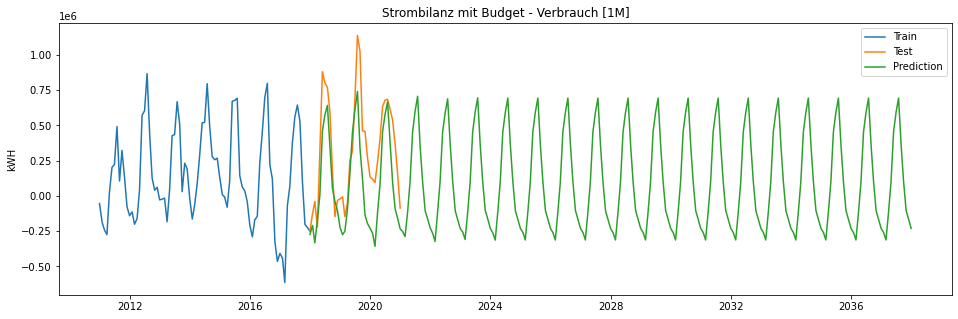

Mean avg percentage error (Test Set bis 2020): 3.6777716086367414
Mean absolute error (Test Set bis 2020): 250460.9377723745


In [331]:
pred_b_isoliert = arima_m_b_isoliert_diff.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Strombilanz mit Budget - Verbrauch Isoliert [1M]')
plt.plot(data_m_isoliert_train["Strombilanz Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_isoliert_test["Strombilanz Schweiz"], label="Test")
plt.plot(pred_b_isoliert, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error (Test Set bis 2020):", mean_absolute_percentage_error(pred_b_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Strombilanz Schweiz"]))
print("Mean absolute error (Test Set bis 2020):", mean_absolute_error(pred_b_isoliert[:'2020-12-31 00:00:00+00:00'], data_m_isoliert_test["Strombilanz Schweiz"]))

Mit dem Arima Modell zeigt es einen stark sinkenden Trend an. Nicht so wie die Rekonstruktion. Die Rekonstruktion zeigt einen sehr sehr schwach sinkenden Trend. Der Unterschied Budget-Verbrauch wurde auch trainiert auf den Trainingsdaten und das Ergebnis ist eine bessere Prognose mit den gleichen Parametern.

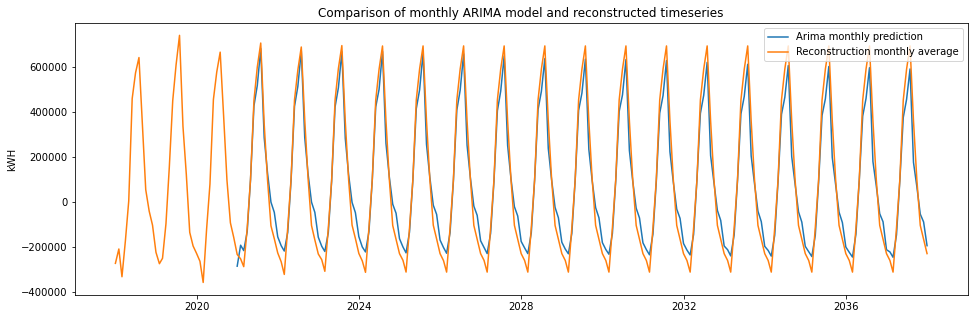

In [334]:
reconstructed = balance_20y_isoliert['2020-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00']
reconstructed_m = reconstructed.resample('M').mean()

plt.figure(figsize=(16,5))
plt.plot(reconstructed_m, label="Arima monthly prediction")
plt.plot(pred_b_isoliert, label="Reconstruction monthly average")
plt.title("Comparison of monthly ARIMA model and reconstructed timeseries")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_generation-pred_consumption, reconstructed_m))
print("Mean absolute error:", mean_absolute_error(pred_generation-pred_consumption, reconstructed_m))

In [340]:
arima_m_p_solar = ARIMA(data_m_solar_train["Strombudget Schweiz"], order=(3, 0, 2), seasonal_order=(2,1,1,12)).fit()
arima_m_v_solar = ARIMA(data_m_solar_train["Stromverbrauch Schweiz"], order=(3, 0, 2), seasonal_order=(2,1,1,12)).fit()
arima_m_b_solar = ARIMA(data_m_solar_train["Strombilanz Schweiz"], order=(5, 0, 3), seasonal_order=(2,1,2,12)).fit()
arima_m_b_solar_diff = ARIMA(data_m_solar_train["Strombudget Schweiz"]-data_m_solar_train["Stromverbrauch Schweiz"], order=(5, 0, 3), seasonal_order=(2,1,2,12)).fit()

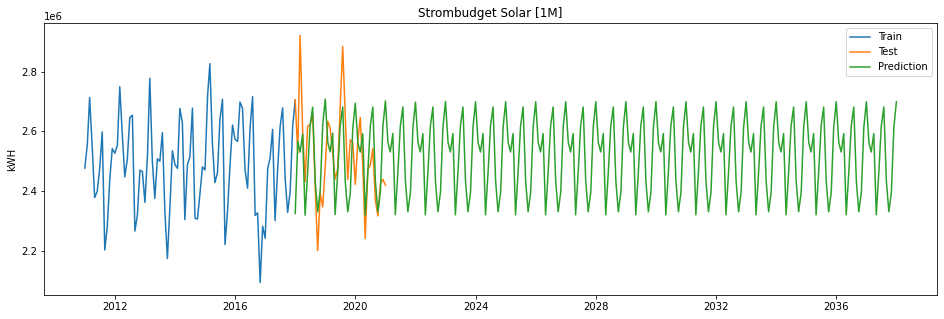

Mean avg percentage error: 0.04690238350251634
Mean absolute error: 118296.57716054912


In [341]:
pred_p_solar = arima_m_p_solar.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Strombudget Solar [1M]')
plt.plot(data_m_solar_train["Strombudget Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_solar_test["Strombudget Schweiz"], label="Test")
plt.plot(pred_p_solar, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_p_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Strombudget Schweiz"]))
print("Mean absolute error:", mean_absolute_error(pred_p_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Strombudget Schweiz"]))

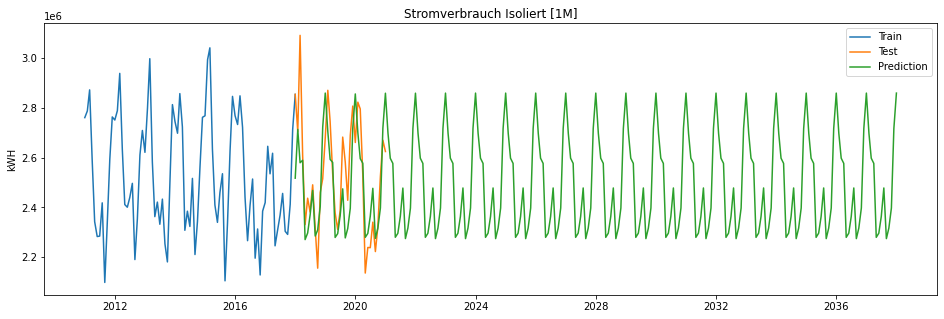

Mean avg percentage error: 0.050995840436901765
Mean absolute error: 128006.14132035786


In [342]:
pred_v_solar = arima_m_v_solar.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Stromverbrauch Solar [1M]')
plt.plot(data_m_solar_train["Stromverbrauch Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_solar_test["Stromverbrauch Schweiz"], label="Test")
plt.plot(pred_v_solar, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_v_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Stromverbrauch Schweiz"]))
print("Mean absolute error:", mean_absolute_error(pred_v_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Stromverbrauch Schweiz"]))

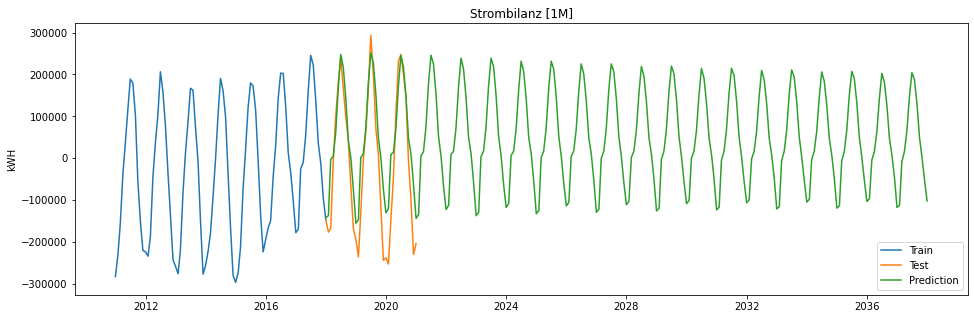

Mean avg percentage error (Test Set bis 2020): 29.46886775309958
Mean absolute error (Test Set bis 2020): 61715.80900410627


In [343]:
pred_b_solar = arima_m_b_solar.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Strombilanz Solar[1M]')
plt.plot(data_m_solar_train["Strombilanz Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_solar_test["Strombilanz Schweiz"], label="Test")
plt.plot(pred_b_solar, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error (Test Set bis 2020):", mean_absolute_percentage_error(pred_b_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Strombilanz Schweiz"]))
print("Mean absolute error (Test Set bis 2020):", mean_absolute_error(pred_b_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Strombilanz Schweiz"]))

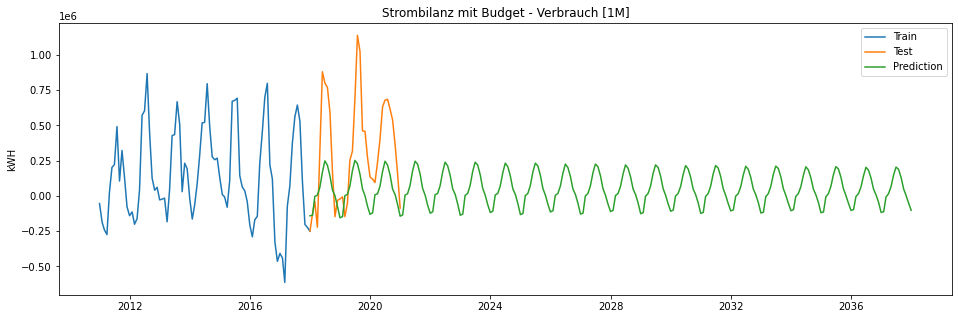

Mean avg percentage error (Test Set bis 2020): 28.715770186788212
Mean absolute error (Test Set bis 2020): 61701.55168575835


In [344]:
pred_b_solar = arima_m_b_solar_diff.predict('2017-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.title('Strombilanz mit Budget - Verbrauch Solar [1M]')
plt.plot(data_m_isoliert_train["Strombilanz Schweiz"]['2010-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_isoliert_test["Strombilanz Schweiz"], label="Test")
plt.plot(pred_b_solar, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error (Test Set bis 2020):", mean_absolute_percentage_error(pred_b_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Strombilanz Schweiz"]))
print("Mean absolute error (Test Set bis 2020):", mean_absolute_error(pred_b_solar[:'2020-12-31 00:00:00+00:00'], data_m_solar_test["Strombilanz Schweiz"]))

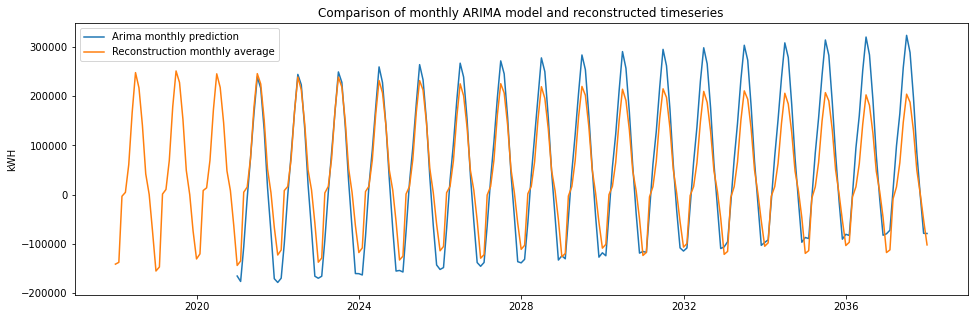

ValueError: Found input variables with inconsistent numbers of samples: [241, 205]

In [346]:
reconstructed = balance_20y_solar['2020-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00']
reconstructed_m = reconstructed.resample('M').mean()

plt.figure(figsize=(16,5))
plt.plot(reconstructed_m, label="Arima monthly prediction")
plt.plot(pred_b_solar, label="Reconstruction monthly average")
plt.title("Comparison of monthly ARIMA model and reconstructed timeseries")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_b_solar[:'2037-12-31 00:00:00+00:00'], reconstructed_m))
print("Mean absolute error:", mean_absolute_error(pred_b_solar, reconstructed_m))

Best dist: lognorm


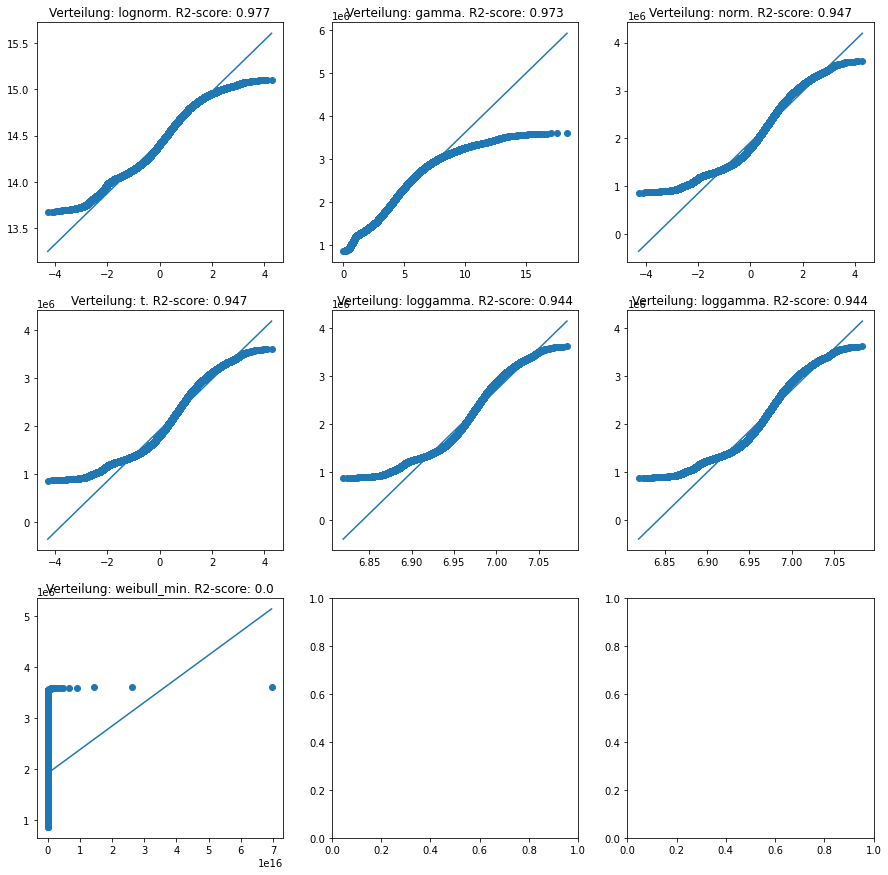

In [352]:
# data
FROM = pd.Timestamp("2018-01-01 00:00:00.000000+00:00")
data = data_selected_isoliert.astype(float).dropna().query('`Zeitstempel` > @FROM')['Strombudget Schweiz']
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.gamma, stats.norm, stats.loggamma, stats.t, stats.weibull_min, stats.loggamma, stats.lognorm]

r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, data)
plt.show()

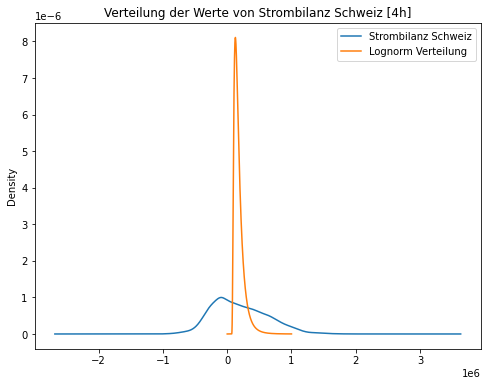

In [357]:
x = np.linspace(0, 1000000, 10000)
distargs = best_dist.fit(data_4h['Strombilanz Schweiz'])

data_4h_isoliert[['Strombilanz Schweiz']].copy().plot.density(title='Verteilung der Werte von Strombilanz Schweiz [4h]', figsize=(8,6))
plt.plot(x, best_dist.pdf(x, *distargs), label='Lognorm Verteilung')
plt.legend()
plt.show()

Best dist: gamma


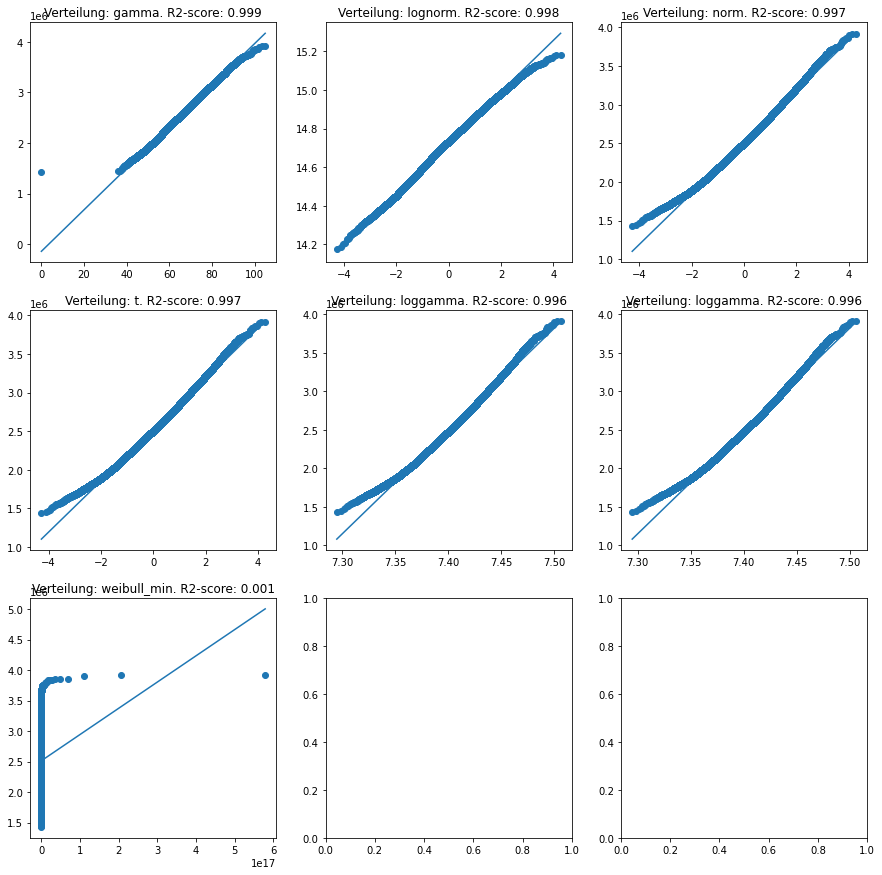

In [358]:
# data
FROM = pd.Timestamp("2018-01-01 00:00:00.000000+00:00")
data = data_selected_solar.astype(float).dropna().query('`Zeitstempel` > @FROM')['Strombudget Schweiz']
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.gamma, stats.norm, stats.loggamma, stats.t, stats.weibull_min, stats.loggamma, stats.lognorm]

r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, data)
plt.show()

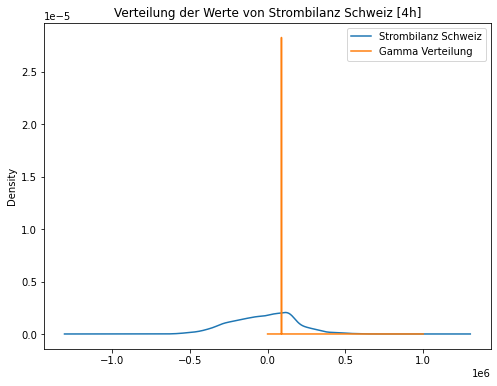

In [360]:
x = np.linspace(0, 1000000, 10000)
distargs = best_dist.fit(data_4h['Strombilanz Schweiz'])

data_4h_solar[['Strombilanz Schweiz']].copy().plot.density(title='Verteilung der Werte von Strombilanz Schweiz [4h]', figsize=(8,6))
plt.plot(x, best_dist.pdf(x, *distargs), label='Gamma Verteilung')
plt.legend()
plt.show()

Gleich wie bei Gesamtdaten. Die Solardaten passen mehr zu den Verteilungen. Die isolierten Daten stimmen überraschenderweise nicht mit den Verteilungen überrein. Bei den isolierten ist die lognorm die beste Verteilung. Bei den Solardaten ist es die Gammaverteilung.

### Fazit

Das additive rekonstruierte Modell ist dem Multiplikativem unterlegen.